![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# **Clinical Relation Extraction Model**

## Setup

In [ ]:
%pip install -q tensorflow==2.7.0
%pip install -q tensorflow-addons

In [1]:
import json
import os

import nlu
import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = start_spark()
spark.sparkContext.setLogLevel("ERROR")

spark

Spark NLP Version : 4.1.0
Spark NLP_JSL Version : 4.1.1a2


## **Posology Releation Extraction**

This is a demonstration of using SparkNLP for extracting posology relations. The following relatios are supported:

DRUG-DOSAGE
DRUG-FREQUENCY
DRUG-ADE (Adversed Drug Events)
DRUG-FORM
DRUG-ROUTE
DRUG-DURATION
DRUG-REASON
DRUG=STRENGTH

The model has been validated against the posology dataset described in (Magge, Scotch, & Gonzalez-Hernandez, 2018).

| Relation | Recall | Precision | F1 | F1 (Magge, Scotch, & Gonzalez-Hernandez, 2018) |
| --- | --- | --- | --- | --- |
| DRUG-ADE | 0.66 | 1.00 | **0.80** | 0.76 |
| DRUG-DOSAGE | 0.89 | 1.00 | **0.94** | 0.91 |
| DRUG-DURATION | 0.75 | 1.00 | **0.85** | 0.92 |
| DRUG-FORM | 0.88 | 1.00 | **0.94** | 0.95* |
| DRUG-FREQUENCY | 0.79 | 1.00 | **0.88** | 0.90 |
| DRUG-REASON | 0.60 | 1.00 | **0.75** | 0.70 |
| DRUG-ROUTE | 0.79 | 1.00 | **0.88** | 0.95* |
| DRUG-STRENGTH | 0.95 | 1.00 | **0.98** | 0.97 |


*Magge, Scotch, Gonzalez-Hernandez (2018) collapsed DRUG-FORM and DRUG-ROUTE into a single relation.

In [3]:
import functools 
import numpy as np
from scipy import spatial
import pyspark.sql.functions as F
import pyspark.sql.types as T
from sparknlp.base import *

**Build pipeline using SparNLP pretrained models and the relation extration model optimized for posology**.
 
 The precision of the RE model is controlled by "setMaxSyntacticDistance(4)", which sets the maximum syntactic distance between named entities to 4. A larger value will improve recall at the expense at lower precision. A value of 4 leads to literally perfect precision (i.e. the model doesn't produce any false positives) and reasonably good recall.

In [4]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = sparknlp.annotators.Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")

words_embedder = WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")

ner_tagger = MedicalNerModel()\
    .pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

ner_chunker = NerConverterInternal()\
    .setInputCols(["sentences", "tokens", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

reModel = RelationExtractionModel()\
    .pretrained("posology_re")\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_chunker,
    dependency_parser,
    reModel
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ]embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
Download done! Loading the resource.
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[ | ]pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
Download done! Loading the resource.


[OK!]
ner_posology download started this may take some time.
[ | ]ner_posology download started this may take some time.
Approximate size to download 13.8 MB
Download done! Loading the resource.


2022-09-22 11:48:07.000137: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[ | ]dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
Download done! Loading the resource.
[ / ]

[ | ]

[OK!]


**Create a light pipeline for annotating free text**

In [4]:
text = """
The patient was prescribed 1 unit of Advil for 5 days after meals. The patient was also 
given 1 unit of Metformin daily.
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 
12 units of insulin lispro with meals , and metformin 1000 mg two times a day.
"""

lmodel = LightPipeline(model)

results = lmodel.fullAnnotate(text)

In [5]:
results[0].keys()

dict_keys(['sentences', 'document', 'ner_chunks', 'ner_tags', 'relations', 'tokens', 'embeddings', 'pos_tags', 'dependencies'])

In [6]:
results[0]['ner_chunks']

[Annotation(chunk, 28, 33, 1 unit, {'chunk': '0', 'confidence': '0.71675', 'ner_source': 'ner_chunks', 'entity': 'DOSAGE', 'sentence': '0'}),
 Annotation(chunk, 38, 42, Advil, {'chunk': '1', 'confidence': '0.9984', 'ner_source': 'ner_chunks', 'entity': 'DRUG', 'sentence': '0'}),
 Annotation(chunk, 44, 53, for 5 days, {'chunk': '2', 'confidence': '0.7455', 'ner_source': 'ner_chunks', 'entity': 'DURATION', 'sentence': '0'}),
 Annotation(chunk, 96, 101, 1 unit, {'chunk': '3', 'confidence': '0.72360003', 'ner_source': 'ner_chunks', 'entity': 'DOSAGE', 'sentence': '1'}),
 Annotation(chunk, 106, 114, Metformin, {'chunk': '4', 'confidence': '0.9998', 'ner_source': 'ner_chunks', 'entity': 'DRUG', 'sentence': '1'}),
 Annotation(chunk, 116, 120, daily, {'chunk': '5', 'confidence': '0.9997', 'ner_source': 'ner_chunks', 'entity': 'FREQUENCY', 'sentence': '1'}),
 Annotation(chunk, 190, 197, 40 units, {'chunk': '6', 'confidence': '0.84085', 'ner_source': 'ner_chunks', 'entity': 'DOSAGE', 'sentence':

In [7]:
results[0]['relations']

[Annotation(category, 28, 42, DOSAGE-DRUG, {'chunk2': 'Advil', 'confidence': '1.0', 'entity2_end': '42', 'chunk1': '1 unit', 'entity2_begin': '38', 'entity1': 'DOSAGE', 'entity1_begin': '28', 'entity1_end': '33', 'entity2': 'DRUG'}),
 Annotation(category, 38, 53, DRUG-DURATION, {'chunk2': 'for 5 days', 'confidence': '1.0', 'entity2_end': '53', 'chunk1': 'Advil', 'entity2_begin': '44', 'entity1': 'DRUG', 'entity1_begin': '38', 'entity1_end': '42', 'entity2': 'DURATION'}),
 Annotation(category, 96, 114, DOSAGE-DRUG, {'chunk2': 'Metformin', 'confidence': '1.0', 'entity2_end': '114', 'chunk1': '1 unit', 'entity2_begin': '106', 'entity1': 'DOSAGE', 'entity1_begin': '96', 'entity1_end': '101', 'entity2': 'DRUG'}),
 Annotation(category, 106, 120, DRUG-FREQUENCY, {'chunk2': 'daily', 'confidence': '1.0', 'entity2_end': '120', 'chunk1': 'Metformin', 'entity2_begin': '116', 'entity1': 'DRUG', 'entity1_begin': '106', 'entity1_end': '114', 'entity2': 'FREQUENCY'}),
 Annotation(category, 190, 217, D

**Show extracted relations**

In [8]:
for rel in results[0]["relations"]:
    print("{}({}={} - {}={})".format(
        rel.result,
        rel.metadata['entity1'], 
        rel.metadata['chunk1'], 
        rel.metadata['entity2'],
        rel.metadata['chunk2']
    ))

DOSAGE-DRUG(DOSAGE=1 unit - DRUG=Advil)
DRUG-DURATION(DRUG=Advil - DURATION=for 5 days)
DOSAGE-DRUG(DOSAGE=1 unit - DRUG=Metformin)
DRUG-FREQUENCY(DRUG=Metformin - FREQUENCY=daily)
DOSAGE-DRUG(DOSAGE=40 units - DRUG=insulin glargine)
DRUG-FREQUENCY(DRUG=insulin glargine - FREQUENCY=at night)
DOSAGE-DRUG(DOSAGE=12 units - DRUG=insulin lispro)
DRUG-FREQUENCY(DRUG=insulin lispro - FREQUENCY=with meals)
DRUG-STRENGTH(DRUG=metformin - STRENGTH=1000 mg)
DRUG-FREQUENCY(DRUG=metformin - FREQUENCY=two times a day)


In [9]:
import pandas as pd

def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result, 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df


rel_df = get_relations_df (results)

rel_df

relation entity1 entity1_begin entity1_end            chunk1  \
0     DOSAGE-DRUG  DOSAGE            28          33            1 unit   
1   DRUG-DURATION    DRUG            38          42             Advil   
2     DOSAGE-DRUG  DOSAGE            96         101            1 unit   
3  DRUG-FREQUENCY    DRUG           106         114         Metformin   
4     DOSAGE-DRUG  DOSAGE           190         197          40 units   
5  DRUG-FREQUENCY    DRUG           202         217  insulin glargine   
6     DOSAGE-DRUG  DOSAGE           231         238          12 units   
7  DRUG-FREQUENCY    DRUG           243         256    insulin lispro   
8   DRUG-STRENGTH    DRUG           275         283         metformin   
9  DRUG-FREQUENCY    DRUG           275         283         metformin   

     entity2 entity2_begin entity2_end            chunk2 confidence  
0       DRUG            38          42             Advil        1.0  
1   DURATION            44          53        for 5 days        1.0  
2       DRUG           106         114         Metformin        1.0  
3  FREQUENCY           116         120             daily        1.0  
4       DRUG           202         217  insulin glargine        1.0  
5  FREQUENCY           219         226          at night        1.0  
6       DRUG           243         256    insulin lispro        1.0  
7  FREQUENCY           258         267        with meals        1.0  
8   STRENGTH           285         291           1000 mg        1.0  
9  FREQUENCY           293         307   two times a day        1.0

In [10]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . 
Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . 
She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . 
Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . 
Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . 
The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . 
The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . 
The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""

annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df



relation   entity1 entity1_begin entity1_end            chunk1  \
0   DURATION-DRUG  DURATION           494         501          five-day   
1   DRUG-DURATION      DRUG           684         696     dapagliflozin   
2      DRUG-ROUTE      DRUG          1947        1953           insulin   
3     DOSAGE-DRUG    DOSAGE          2263        2270          40 units   
4  DRUG-FREQUENCY      DRUG          2275        2290  insulin glargine   
5     DOSAGE-DRUG    DOSAGE          2303        2310          12 units   
6  DRUG-FREQUENCY      DRUG          2315        2328    insulin lispro   
7   DRUG-STRENGTH      DRUG          2347        2355         metformin   
8  DRUG-FREQUENCY      DRUG          2347        2355         metformin   

     entity2 entity2_begin entity2_end            chunk2 confidence  
0       DRUG           513         523       amoxicillin        1.0  
1   DURATION           698         711    for six months        1.0  
2      ROUTE          1955        1958              drip        1.0  
3       DRUG          2275        2290  insulin glargine        1.0  
4  FREQUENCY          2292        2299          at night        1.0  
5       DRUG          2315        2328    insulin lispro        1.0  
6  FREQUENCY          2330        2339        with meals        1.0  
7   STRENGTH          2357        2363           1000 mg        1.0  
8  FREQUENCY          2365        2379   two times a day        1.0

**Visualization of Extracted Relations**

In [11]:
text = """
The patient was prescribed 1 unit of Advil for 5 days after meals. The patient was also 
given 1 unit of Metformin daily.
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine , 
12 units of insulin lispro with meals , and metformin two times a day.
"""

lmodel = LightPipeline(model)

results = lmodel.fullAnnotate(text)

In [12]:
from sparknlp_display import RelationExtractionVisualizer


vis = RelationExtractionVisualizer()
vis.display(results[0], 'relations', show_relations=True) # default show_relations: True


## **ADE Relation Extraction**

We can extract relations between `DRUG` and adverse reactions `ADE` caused by them. Also we can find if an adverse event is caused by a drug or not.

`1`: Shows the adverse event and drug entities are related.

`0`: Shows the adverse event and drug entities are not related.

Now we will first use `ner_ade_clinical` NER model and detect `DRUG` and `ADE` entities. Then we ca find the relations between them by using `re_ade_clinical` model. We can also use the same pipeline elemnets rest of them we created above.

In [13]:
ner_tagger = MedicalNerModel.pretrained("ner_ade_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")  

reModel = RelationExtractionModel()\
    .pretrained("re_ade_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(10)\
    .setRelationPairs(["drug-ade, ade-drug"])\
    .setRelationPairsCaseSensitive(False)     # it will return any "ade-drug" or "ADE-DRUG" relationship. By default it’s set to False
                                              # True, then the pairs of entities in the dataset should match the pairs in setRelationPairs in their specific case (case sensitive). 
                                              # False, meaning that the match of those relation names is case insensitive.
ade_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_chunker,
    dependency_parser,
    reModel
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_model = ade_pipeline.fit(empty_data)

ner_ade_clinical download started this may take some time.
[ | ]ner_ade_clinical download started this may take some time.
Approximate size to download 13.9 MB
Download done! Loading the resource.


2022-09-22 10:59:25.113343: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
re_ade_clinical download started this may take some time.
Approximate size to download 10.9 MB
[ | ]re_ade_clinical download started this may take some time.
Approximate size to download 10.9 MB
Download done! Loading the resource.
[OK!]


**Show the classes**

In [14]:
reModel.getClasses()

['0', '1']

**We will create a LightPipeline for annotation.**

In [15]:
ade_lmodel = LightPipeline(ade_model)

In [16]:
text = "I experienced fatigue, muscle cramps, anxiety, agression and sadness after taking Lipitor but no more adverse after passing Zocor."

ade_results = ade_lmodel.fullAnnotate(text)

In [17]:
ade_results[0].keys()

dict_keys(['sentences', 'document', 'ner_chunks', 'ner_tags', 'relations', 'tokens', 'embeddings', 'pos_tags', 'dependencies'])

In [18]:
ade_results[0]["ner_chunks"]

[Annotation(chunk, 14, 20, fatigue, {'chunk': '0', 'confidence': '0.8692', 'ner_source': 'ner_chunks', 'entity': 'ADE', 'sentence': '0'}),
 Annotation(chunk, 23, 35, muscle cramps, {'chunk': '1', 'confidence': '0.9433', 'ner_source': 'ner_chunks', 'entity': 'ADE', 'sentence': '0'}),
 Annotation(chunk, 38, 44, anxiety, {'chunk': '2', 'confidence': '0.9881', 'ner_source': 'ner_chunks', 'entity': 'ADE', 'sentence': '0'}),
 Annotation(chunk, 47, 55, agression, {'chunk': '3', 'confidence': '0.9664', 'ner_source': 'ner_chunks', 'entity': 'ADE', 'sentence': '0'}),
 Annotation(chunk, 61, 67, sadness, {'chunk': '4', 'confidence': '0.9415', 'ner_source': 'ner_chunks', 'entity': 'ADE', 'sentence': '0'}),
 Annotation(chunk, 82, 88, Lipitor, {'chunk': '5', 'confidence': '0.9945', 'ner_source': 'ner_chunks', 'entity': 'DRUG', 'sentence': '0'}),
 Annotation(chunk, 124, 128, Zocor, {'chunk': '6', 'confidence': '0.9271', 'ner_source': 'ner_chunks', 'entity': 'DRUG', 'sentence': '0'})]

**Lets show the `ADE`-`DRUG` relations by using pandas dataframe.**

In [19]:
ade_results = ade_lmodel.fullAnnotate(text)

rel_df = get_relations_df(ade_results)

rel_df

relation entity1 entity1_begin entity1_end         chunk1 entity2  \
0        1     ADE            14          20        fatigue    DRUG   
1        0     ADE            14          20        fatigue    DRUG   
2        1     ADE            23          35  muscle cramps    DRUG   
3        0     ADE            23          35  muscle cramps    DRUG   
4        1     ADE            38          44        anxiety    DRUG   
5        0     ADE            38          44        anxiety    DRUG   
6        1     ADE            47          55      agression    DRUG   
7        0     ADE            47          55      agression    DRUG   
8        1     ADE            61          67        sadness    DRUG   
9        0     ADE            61          67        sadness    DRUG   

  entity2_begin entity2_end   chunk2  confidence  
0            82          88  Lipitor   0.9996617  
1           124         128    Zocor   0.9952187  
2            82          88  Lipitor   0.9999827  
3           124         128    Zocor  0.91462934  
4            82          88  Lipitor   0.7636133  
5           124         128    Zocor   0.9999691  
6            82          88  Lipitor  0.99999833  
7           124         128    Zocor  0.99781835  
8            82          88  Lipitor         1.0  
9           124         128    Zocor   0.9999572

**Visualization of relations**

In [20]:
vis = RelationExtractionVisualizer()

vis.display(ade_results[0], 'relations', show_relations=True)


**Lets set custom labels instead of default ones by using  `.setCustomLabels()` parameter**

In [21]:
reModel = RelationExtractionModel()\
    .pretrained("re_ade_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(10)\
    .setRelationPairs(["drug-ade, ade-drug"])

# set custom labels
reModel.setCustomLabels({"1": "is_related", "0": "not_related"})


ade_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_chunker,
    dependency_parser,
    reModel
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_model = ade_pipeline.fit(empty_data)

re_ade_clinical download started this may take some time.
Approximate size to download 10.9 MB
[OK!]


In [22]:
ade_lmodel = LightPipeline(ade_model)

text ="""A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands."""

ade_results = ade_lmodel.fullAnnotate(text)

In [23]:
print(text)

rel_df = get_relations_df (ade_results)

rel_df


A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands.


relation entity1 entity1_begin entity1_end     chunk1 entity2  \
0  is_related    DRUG            25          32   naproxen     ADE   
1  is_related    DRUG            25          32   naproxen     ADE   
2  is_related    DRUG            87          95  oxaprozin     ADE   
3  is_related    DRUG            87          95  oxaprozin     ADE   

  entity2_begin entity2_end  \
0           137         148   
1           154         210   
2           137         148   
3           154         210   

                                              chunk2  confidence  
0                                       tense bullae         1.0  
1  cutaneous fragility on the face and the back o...  0.99999964  
2                                       tense bullae         1.0  
3  cutaneous fragility on the face and the back o...         1.0

In [24]:
vis = RelationExtractionVisualizer()

vis.display(ade_results[0], 'relations', show_relations=True)

## **Clinical RE**

**The set of relations defined in the 2010 i2b2 relation challenge**

TrIP: A certain treatment has improved or cured a medical problem (eg, ‘infection resolved with antibiotic course’)

TrWP: A patient's medical problem has deteriorated or worsened because of or in spite of a treatment being administered (eg, ‘the tumor was growing despite the drain’)

TrCP: A treatment caused a medical problem (eg, ‘penicillin causes a rash’)

TrAP: A treatment administered for a medical problem (eg, ‘Dexamphetamine for narcolepsy’)

TrNAP: The administration of a treatment was avoided because of a medical problem (eg, ‘Ralafen which is contra-indicated because of ulcers’)

TeRP: A test has revealed some medical problem (eg, ‘an echocardiogram revealed a pericardial effusion’)

TeCP: A test was performed to investigate a medical problem (eg, ‘chest x-ray done to rule out pneumonia’)

PIP: Two problems are related to each other (eg, ‘Azotemia presumed secondary to sepsis’)

In [25]:
clinical_ner_tagger = MedicalNerModel()\
    .pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

clinical_re_Model = RelationExtractionModel()\
    .pretrained("re_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setRelationPairs(["problem-test", "problem-treatment"]) # we can set the possible relation pairs (if not set, all the relations will be calculated)

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    clinical_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_clinical download started this may take some time.
[ | ]ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
Download done! Loading the resource.


2022-09-22 10:59:52.582558: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
re_clinical download started this may take some time.
Approximate size to download 6 MB
[ | ]re_clinical download started this may take some time.
Approximate size to download 6 MB
Download done! Loading the resource.
[OK!]


In [26]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df[rel_df.relation!="O"]


relation  entity1 entity1_begin entity1_end                chunk1  \
11     TrAP  PROBLEM           617         620                  T2DM   
15     TeRP     TEST           739         758  Physical examination   
19     TrWP     TEST          1246        1258         blood samples   
21     TeRP     TEST          1535        1547         the anion gap   
26     TrAP     TEST          1838        1845              analysis   
33     TrAP  PROBLEM          1967        1969                   HTG   
34     TrAP  PROBLEM          1967        1969                   HTG   

      entity2 entity2_begin entity2_end                       chunk2  \
11  TREATMENT           626         637                 atorvastatin   
15    PROBLEM           796         810              dry oral mucosa   
19    PROBLEM          1265        1274                   hemolyzing   
21    PROBLEM          1553        1566               still elevated   
26    PROBLEM          1854        1880  interference from turbidity   
33  TREATMENT          1976        1986                  a reduction   
34       TEST          1991        2003                the anion gap   

    confidence  
11  0.99955326  
15   0.9994142  
19   0.9854173  
21   0.9965193  
26   0.9676019  
33   0.9875973  
34   0.9993911

## Clinical Temporal Events RE

Temporal relations, or temporal links (denoted by the TLINK tag), indicate whether and how two EVENTs, two TIME, or an EVENT and a TIME related to each other in the clinical timeline. There are 3 type of relations here and below are some examples of Relations, with square brackets indicating EVENT and TIME connected by a temporal link:

**`BEFORE`**

The patient was given stress dose steroids prior to his surgery. ([stress dose steroids] `BEFORE` [his surgery])

The patient had an undocumented history of possible atrial fibrillation prior to admission. ([possible atrial fibrillation] `BEFORE` [admission])

His nasogastric tube was discontinued on 05-26-98. ([His nasogastric] `BEFORE` [05-26-98])

**`AFTER`**

Before admission, he had another serious concussion. ([admission] `AFTER` [another serious concussion])

On postoperative day No 1, he was started on Percocet. ([Percocet] `AFTER` [postoperative day No 1])


**`OVERLAP`**

She denies any fevers or chills. ([fevers] `OVERLAP` [chills])

The patient's serum creatinine on discharge date, 2012-05-06, was 1.9. ([discharge date] `OVERLAP` [2012-05-06])

His preoperative workup was completed and included a normal white count ([a normal white count] `OVERLAP` [His preoperative workup])

The patient had an undocumented history of possible atrial fibrillation prior to admission. ([possible atrial fibrillation] `OVERLAP` [admission])


| Relation | Recall | Precision | F1 |
| --- | --- | --- | --- |
| OVERLAP | 0.81 | 0.73 | **0.77** |
| BEFORE | 0.85 | 0.88 | **0.86** |
| AFTER | 0.38 | 0.46 | **0.43** |



This RE model works with `ner_events_clinical` NER model and expect the following entities as inputs:

[`OCCURRENCE`,
 `DATE`,
 `DURATION`,
 `EVIDENTIAL`,
 `TEST`,
 `PROBLEM`,
 `TREATMENT`,
 `CLINICAL_DEPT`,
 `FREQUENCY`,
 `TIME`]

In [27]:
events_ner_tagger = MedicalNerModel()\
    .pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

clinical_re_Model = RelationExtractionModel()\
    .pretrained("re_temporal_events_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    events_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_events_clinical download started this may take some time.
[ | ]ner_events_clinical download started this may take some time.
Approximate size to download 13.8 MB
Download done! Loading the resource.
[ / ]

2022-09-22 11:00:01.901168: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
re_temporal_events_clinical download started this may take some time.
Approximate size to download 5.9 MB
[ | ]re_temporal_events_clinical download started this may take some time.
Approximate size to download 5.9 MB
Download done! Loading the resource.
[OK!]


In [28]:
events_ner_tagger.getClasses()

['O',
 'B-OCCURRENCE',
 'B-DATE',
 'B-PROBLEM',
 'I-PROBLEM',
 'B-DURATION',
 'I-DURATION',
 'B-EVIDENTIAL',
 'I-OCCURRENCE',
 'B-TREATMENT',
 'I-TREATMENT',
 'I-DATE',
 'B-TEST',
 'I-TEST',
 'B-CLINICAL_DEPT',
 'I-CLINICAL_DEPT',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'I-EVIDENTIAL',
 'B-TIME',
 'I-TIME']

In [29]:
text = "She had a retinal degeneration after the accident in 2005 May"

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df

relation     entity1 entity1_begin entity1_end                  chunk1  \
0    AFTER     PROBLEM             8          29  a retinal degeneration   
1    AFTER     PROBLEM             8          29  a retinal degeneration   
2  OVERLAP  OCCURRENCE            37          48            the accident   

      entity2 entity2_begin entity2_end        chunk2  confidence  
0  OCCURRENCE            37          48  the accident         1.0  
1        DATE            53          60      2005 May  0.99998236  
2        DATE            53          60      2005 May   0.9999902

In [30]:
text ="On 9–28-92, the patient will return for chemotherapy and she will follow up with her primary doctor, for PT and Coumadin dosing on Monday."

annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df[(rel_df.relation!="O")&(rel_df.entity1!=rel_df.entity2)]


relation        entity1 entity1_begin entity1_end              chunk1  \
0   OVERLAP           DATE             3           9             9–28-92   
1   OVERLAP           DATE             3           9             9–28-92   
3   OVERLAP     OCCURRENCE            66          74           follow up   
4   OVERLAP     OCCURRENCE            66          74           follow up   
5   OVERLAP     OCCURRENCE            66          74           follow up   
6   OVERLAP  CLINICAL_DEPT            81          98  her primary doctor   
7   OVERLAP  CLINICAL_DEPT            81          98  her primary doctor   
9     AFTER      TREATMENT           105         106                  PT   
10  OVERLAP      TREATMENT           112         126     Coumadin dosing   

          entity2 entity2_begin entity2_end              chunk2  confidence  
0       TREATMENT            40          51        chemotherapy    1.000000  
1       TREATMENT           105         106                  PT    0.989851  
3   CLINICAL_DEPT            81          98  her primary doctor    0.998086  
4       TREATMENT           105         106                  PT    0.999761  
5       TREATMENT           112         126     Coumadin dosing    0.958726  
6       TREATMENT           105         106                  PT    1.000000  
7            DATE           131         136              Monday    0.984193  
9            DATE           131         136              Monday    0.926052  
10           DATE           131         136              Monday    0.999999

**Admission-Discharge Events Exraction**

We can also extract `ADMISSION` and `DISCHARGE` entities in addition to `ner_events_clinical` model entities using `ner_events_admission_clinical` NER model and expect the following entities as inputs:
   
[`EVIDENTIAL`,
 `OCCURRENCE`,
 `TREATMENT`,
 `DATE`,
 `ADMISSION`,
 `TIME`,
 `FREQUENCY`,
 `CLINICAL_DEPT`,
 `DURATION`,
 `PROBLEM`,
 `TEST`,
 `DISCHARGE`]

In [31]:
events_admission_ner_tagger = MedicalNerModel()\
    .pretrained("ner_events_admission_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    events_admission_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_events_admission_clinical download started this may take some time.
[ | ]ner_events_admission_clinical download started this may take some time.
Approximate size to download 14.5 MB
Download done! Loading the resource.
[ / ]

2022-09-22 11:00:10.955254: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]


In [32]:
events_admission_ner_tagger.getClasses()

['O',
 'B-EVIDENTIAL',
 'I-OCCURRENCE',
 'I-TREATMENT',
 'I-DATE',
 'B-ADMISSION',
 'B-TREATMENT',
 'I-TIME',
 'I-FREQUENCY',
 'B-FREQUENCY',
 'B-OCCURRENCE',
 'I-CLINICAL_DEPT',
 'B-DURATION',
 'I-PROBLEM',
 'I-TEST',
 'B-DATE',
 'B-TIME',
 'I-EVIDENTIAL',
 'I-DURATION',
 'B-DISCHARGE',
 'B-TEST',
 'B-PROBLEM',
 'B-CLINICAL_DEPT']

In [33]:
text ="""She is admitted to The John Hopkins Hospital on Monday with a history of gestational diabetes mellitus diagnosed.  
She was seen by the endocrinology service and she was discharged on 03/02/2018 on 40 units of insulin glargine, 
12 units of insulin lispro, and metformin 1000 mg two times a day. She had close follow-up with endocrinology post discharge. 
"""

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df[(rel_df.relation!="O")]


relation        entity1 entity1_begin entity1_end  \
0     AFTER      ADMISSION             7          14   
1   OVERLAP      ADMISSION             7          14   
2   OVERLAP  CLINICAL_DEPT            19          43   
3   OVERLAP           DATE            48          53   
4   OVERLAP  CLINICAL_DEPT           132         156   
5   OVERLAP      DISCHARGE           170         179   
6     AFTER      DISCHARGE           170         179   
7     AFTER      DISCHARGE           170         179   
8   OVERLAP           DATE           184         193   
9   OVERLAP           DATE           184         193   
10  OVERLAP      TREATMENT           261         269   
11  OVERLAP     OCCURRENCE           304         318   
12   BEFORE     OCCURRENCE           304         318   
13    AFTER  CLINICAL_DEPT           325         337   

                       chunk1        entity2 entity2_begin entity2_end  \
0                    admitted  CLINICAL_DEPT            19          43   
1                    admitted           DATE            48          53   
2   The John Hopkins Hospital           DATE            48          53   
3                      Monday        PROBLEM            73         101   
4   the endocrinology service           DATE           184         193   
5                  discharged           DATE           184         193   
6                  discharged      TREATMENT           210         225   
7                  discharged      TREATMENT           241         254   
8                  03/02/2018      TREATMENT           210         225   
9                  03/02/2018      TREATMENT           241         254   
10                  metformin      FREQUENCY           279         293   
11            close follow-up  CLINICAL_DEPT           325         337   
12            close follow-up      DISCHARGE           344         352   
13              endocrinology      DISCHARGE           344         352   

                           chunk2  confidence  
0       The John Hopkins Hospital    0.993847  
1                          Monday    0.991630  
2                          Monday    1.000000  
3   gestational diabetes mellitus    0.929829  
4                      03/02/2018    0.999932  
5                      03/02/2018    1.000000  
6                insulin glargine    0.999233  
7                  insulin lispro    0.997469  
8                insulin glargine    0.999975  
9                  insulin lispro    0.999682  
10                two times a day    1.000000  
11                  endocrinology    1.000000  
12                      discharge    0.998952  
13                      discharge    0.999982

**Test-Result-Date Extraction**

There is another Relation Extraction model to link clinical tests to test results and dates to clinical entities: `re_test_result_date`

In [34]:
trd_ner_tagger = MedicalNerModel()\
    .pretrained("jsl_ner_wip_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")       

trd_re_Model = RelationExtractionModel()\
    .pretrained("re_test_result_date", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    trd_ner_tagger,
    ner_chunker,
    dependency_parser,
    trd_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

jsl_ner_wip_clinical download started this may take some time.
[ | ]jsl_ner_wip_clinical download started this may take some time.
Approximate size to download 14.5 MB
Download done! Loading the resource.
[ / ]

2022-09-22 11:00:17.137111: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
re_test_result_date download started this may take some time.
Approximate size to download 9.3 MB
[ | ]re_test_result_date download started this may take some time.
Approximate size to download 9.3 MB
Download done! Loading the resource.
[OK!]


In [35]:
text = 'Hospitalized with pneumonia on 11 June 2019, confirmed by a positive PCR of any specimen, evidenced by SPO2 </= 93%.'

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df[(rel_df.relation!="O")]

relation                    entity1 entity1_begin entity1_end  \
0     is_date_of  Disease_Syndrome_Disorder            18          26   
3  is_finding_of  Disease_Syndrome_Disorder            18          26   
6     is_date_of                       Date            31          42   
7   is_result_of                Test_Result            60          67   
8   is_result_of                Test_Result            60          67   

         chunk1        entity2 entity2_begin entity2_end        chunk2  \
0     pneumonia           Date            31          42  11 June 2019   
3     pneumonia  O2_Saturation           103         114  SPO2 </= 93%   
6  11 June 2019  O2_Saturation           103         114  SPO2 </= 93%   
7      positive           Test            69          71           PCR   
8      positive  O2_Saturation           103         114  SPO2 </= 93%   

   confidence  
0    0.998061  
3    0.984967  
6    0.993791  
7    1.000000  
8    1.000000

## Human Phenotype - Gene RE

https://github.com/lasigeBioTM/PGR

Human phenotype-gene relations are fundamental to fully understand the origin of some phenotypic abnormalities and their associated diseases. Biomedical literature is the most comprehensive source of these relations, however, we need Relation Extraction tools to automatically recognize them. We present the Phenotype-Gene Relations (PGR) model, trained on a silver standard corpus of human phenotype and gene annotations and their relations. 

It extracts 2 label: `True` or `False`


In [36]:
pgr_ner_tagger = MedicalNerModel()\
    .pretrained("ner_human_phenotype_gene_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

pgr_re_Model = RelationExtractionModel()\
    .pretrained("re_human_phenotype_gene_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["hp-gene",'gene-hp'])\
    .setMaxSyntacticDistance(4)\

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    pgr_ner_tagger,
    ner_chunker,
    dependency_parser,
    pgr_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_human_phenotype_gene_clinical download started this may take some time.
[ | ]ner_human_phenotype_gene_clinical download started this may take some time.
Approximate size to download 14 MB
Download done! Loading the resource.


2022-09-22 11:00:24.966951: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
re_human_phenotype_gene_clinical download started this may take some time.
Approximate size to download 5.9 MB
[ | ]re_human_phenotype_gene_clinical download started this may take some time.
Approximate size to download 5.9 MB
Download done! Loading the resource.
[OK!]


In [37]:
text = "She has a retinal degeneration, hearing loss and renal failure, short stature, \
Mutations in the SH3PXD2B gene coding for the Tks4 protein are responsible for the autosomal recessive."

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!='0')]

rel_df

relation entity1 entity1_begin entity1_end         chunk1 entity2  \
0        1      HP            32          43   hearing loss    GENE   
1        1      HP            49          61  renal failure    GENE   
2        1      HP            64          76  short stature    GENE   

  entity2_begin entity2_end    chunk2  confidence  
0            96         103  SH3PXD2B  0.99999976  
1            96         103  SH3PXD2B   0.9998969  
2            96         103  SH3PXD2B  0.99994695

## **Drug-Drug Interaction RE**

In clinical application, two or more drugs are often used in combination to achieve conducive results, such as synergistic effect, increasing therapeutic effect and reducing or delaying the occurrence of
drug resistance. However, there is a potential for harmful drug-drug
interactions (DDIs) to occur when two or more drugs are taken at the
same time or at certain interval, which can reduce or invalidate the
efficacy of drugs, and increase toxicity or even cause death. Therefore,
in order to prevent harmful drug-drug interaction (DDI), medical staff
often spend much time in reviewing the relevant drug alert literature
and drug knowledge bases. 

**ref**: *Drug-drug interaction extraction via hybrid neural networks on biomedical literature
https://www-sciencedirect-com.ezproxy.leidenuniv.nl:2443/science/article/pii/S1532046420300605*

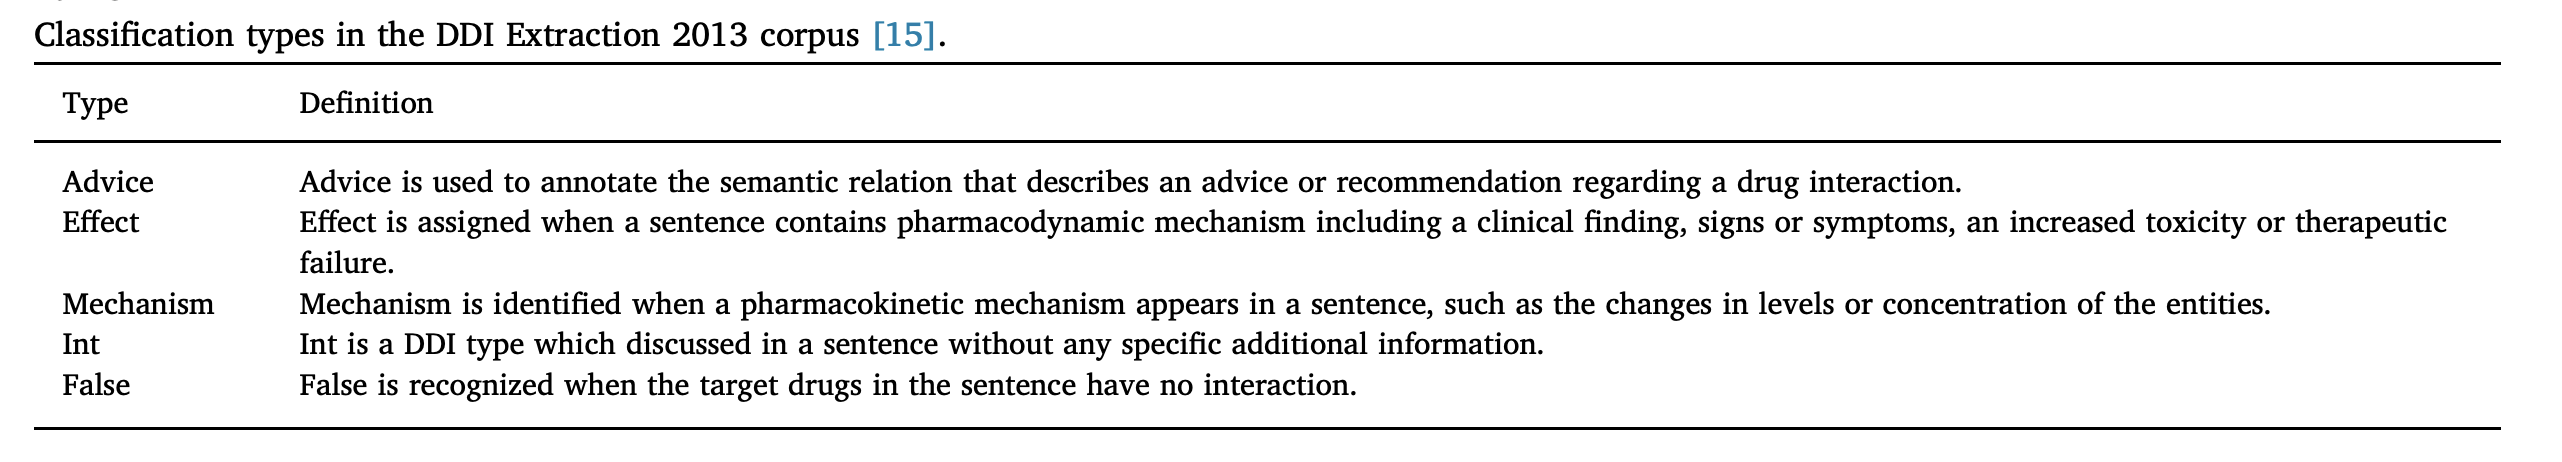

In [38]:
ner_tagger = MedicalNerModel()\
    .pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ner_converter = NerConverterInternal() \
    .setInputCols(["sentences", "tokens", "ner_tags"]) \
    .setOutputCol("ner_chunk")

ddi_re_model = RelationExtractionModel()\
    .pretrained("re_drug_drug_interaction_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["drug-drug"])\
    .setMaxSyntacticDistance(4)\

ddi_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_converter,
    dependency_parser,
    ddi_re_model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ddi_model = ddi_pipeline.fit(empty_data)

ner_posology download started this may take some time.
[OK!]
re_drug_drug_interaction_clinical download started this may take some time.
Approximate size to download 4.6 MB
[ | ]re_drug_drug_interaction_clinical download started this may take some time.
Approximate size to download 4.6 MB
Download done! Loading the resource.
[OK!]


In [39]:
text='When carbamazepine is withdrawn from the combination therapy, aripiprazole dose should then be reduced. \
If additional adrenergic drugs are to be administered by any route, \
they should be used with caution because the pharmacologically predictable sympathetic effects of Metformin may be potentiated'

lmodel = LightPipeline(ddi_model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)


rel_df

relation entity1 entity1_begin entity1_end         chunk1 entity2  \
0  DDI-advise    DRUG             5          17  carbamazepine    DRUG   

  entity2_begin entity2_end        chunk2  confidence  
0            62          73  aripiprazole  0.99238014

In [40]:
annotations[0]['ner_chunk']

[Annotation(chunk, 5, 17, carbamazepine, {'chunk': '0', 'confidence': '0.9968', 'ner_source': 'ner_chunk', 'entity': 'DRUG', 'sentence': '0'}),
 Annotation(chunk, 62, 73, aripiprazole, {'chunk': '1', 'confidence': '0.9998', 'ner_source': 'ner_chunk', 'entity': 'DRUG', 'sentence': '0'}),
 Annotation(chunk, 118, 133, adrenergic drugs, {'chunk': '2', 'confidence': '0.7984', 'ner_source': 'ner_chunk', 'entity': 'DRUG', 'sentence': '1'}),
 Annotation(chunk, 270, 278, Metformin, {'chunk': '3', 'confidence': '0.9998', 'ner_source': 'ner_chunk', 'entity': 'DRUG', 'sentence': '1'})]

## **Drug-Protein Interaction RE**

Detect interactions between chemical compounds/drugs and genes/proteins using Spark NLP’s `RelationExtractionModel()` by classifying whether a specified semantic relation holds between a chemical and gene entities within a sentence or document. <br/>

The entity labels used during training were derived from the custom NER model created by our team for the **DrugProt** corpus. These include `CHEMICAL` for chemical compounds/drugs, `GENE` for genes/proteins and `GENE_AND_CHEMICAL` for entity mentions of type `GENE` and of type `CHEMICAL` that overlap (such as enzymes and small peptides). <br/>

The relation categories from the **DrugProt** corpus were condensed from 13 categories to 10 categories due to low numbers of examples for certain categories. This merging process involved grouping the `SUBSTRATE_PRODUCT-OF` and `SUBSTRATE` relation categories together and grouping the `AGONIST-ACTIVATOR`, `AGONIST-INHIBITOR` and `AGONIST` relation categories together.

**ref**: *DrugProt corpus: Biocreative VII Track 1 - Text mining drug and chemical-protein interactionshttps://zenodo.org/record/5119892*

In [41]:
drugprot_ner_tagger = MedicalNerModel.pretrained("ner_drugprot_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ner_converter = NerConverter()\
    .setInputCols(["sentences", "tokens", "ner_tags"])\
    .setOutputCol("ner_chunks")

drugprot_re_model = RelationExtractionModel()\
    .pretrained("re_drugprot_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.5)\
    .setRelationPairs(["checmical-gene", "chemical-gene_and_chemical", "gene_and_chemical-gene"]) 

pipeline = Pipeline(stages=[
        documenter, 
        sentencer,
        tokenizer,
        words_embedder, 
        drugprot_ner_tagger,
        ner_converter, 
        pos_tagger, 
        dependency_parser, 
        drugprot_re_model])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_drugprot_clinical download started this may take some time.
[ | ]ner_drugprot_clinical download started this may take some time.
Approximate size to download 14 MB
Download done! Loading the resource.
[ / ]

2022-09-22 11:00:44.806352: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
AddV2: CPU 
Unique: CPU 
Mul: CPU 
VariableV2: CPU 
Assign: CPU 
Shape: CPU 
Identity: CPU 
Cast: CPU 
Sub: CPU 
GatherV2: CPU

[OK!]
re_drugprot_clinical download started this may take some time.
Approximate size to download 9.2 MB
[ | ]re_drugprot_clinical download started this may take some time.
Approximate size to download 9.2 MB
Download done! Loading the resource.
[OK!]


In [42]:
text='''Lipid specific activation of the murine P4-ATPase Atp8a1 (ATPase II). The asymmetric transbilayer distribution of phosphatidylserine (PS) in the mammalian plasma membrane and secretory vesicles is maintained, in part, by an ATP-dependent transporter. This aminophospholipid "flippase" selectively transports PS to the cytosolic leaflet of the bilayer and is sensitive to vanadate, Ca(2+), and modification by sulfhydryl reagents. Although the flippase has not been positively identified, a subfamily of P-type ATPases has been proposed to function as transporters of amphipaths, including PS and other phospholipids. A candidate PS flippase ATP8A1 (ATPase II), originally isolated from bovine secretory vesicles, is a member of this subfamily based on sequence homology to the founding member of the subfamily, the yeast protein Drs2, which has been linked to ribosomal assembly, the formation of Golgi-coated vesicles, and the maintenance of PS asymmetry. To determine if ATP8A1 has biochemical characteristics consistent with a PS flippase, a murine homologue of this enzyme was expressed in insect cells and purified. The purified Atp8a1 is inactive in detergent micelles or in micelles containing phosphatidylcholine, phosphatidic acid, or phosphatidylinositol, is minimally activated by phosphatidylglycerol or phosphatidylethanolamine (PE), and is maximally activated by PS. The selectivity for PS is dependent upon multiple elements of the lipid structure. Similar to the plasma membrane PS transporter, Atp8a1 is activated only by the naturally occurring sn-1,2-glycerol isomer of PS and not the sn-2,3-glycerol stereoisomer. Both flippase and Atp8a1 activities are insensitive to the stereochemistry of the serine headgroup. Most modifications of the PS headgroup structure decrease recognition by the plasma membrane PS flippase. Activation of Atp8a1 is also reduced by these modifications; phosphatidylserine-O-methyl ester, lysophosphatidylserine, glycerophosphoserine, and phosphoserine, which are not transported by the plasma membrane flippase, do not activate Atp8a1. Weakly translocated lipids (PE, phosphatidylhydroxypropionate, and phosphatidylhomoserine) are also weak Atp8a1 activators. However, N-methyl-phosphatidylserine, which is transported by the plasma membrane flippase at a rate equivalent to PS, is incapable of activating Atp8a1 activity. These results indicate that the ATPase activity of the secretory granule Atp8a1 is activated by phospholipids binding to a specific site whose properties (PS selectivity, dependence upon glycerol but not serine, stereochemistry, and vanadate sensitivity) are similar to, but distinct from, the properties of the substrate binding site of the plasma membrane flippase.'''

lmodel = LightPipeline(model)

results = lmodel.fullAnnotate(text)

In [43]:
results[0].keys()

dict_keys(['sentences', 'document', 'ner_chunks', 'ner_tags', 'relations', 'tokens', 'embeddings', 'pos_tags', 'dependencies'])

In [44]:
results[0]["ner_chunks"]

[Annotation(chunk, 33, 48, murine P4-ATPase, {'entity': 'GENE', 'sentence': '0', 'chunk': '0', 'confidence': '0.75505'}),
 Annotation(chunk, 50, 55, Atp8a1, {'entity': 'GENE', 'sentence': '0', 'chunk': '1', 'confidence': '0.9911'}),
 Annotation(chunk, 58, 66, ATPase II, {'entity': 'GENE', 'sentence': '0', 'chunk': '2', 'confidence': '0.8749'}),
 Annotation(chunk, 114, 131, phosphatidylserine, {'entity': 'CHEMICAL', 'sentence': '1', 'chunk': '3', 'confidence': '0.9794'}),
 Annotation(chunk, 134, 135, PS, {'entity': 'CHEMICAL', 'sentence': '1', 'chunk': '4', 'confidence': '0.7845'}),
 Annotation(chunk, 224, 248, ATP-dependent transporter, {'entity': 'GENE_AND_CHEMICAL', 'sentence': '1', 'chunk': '5', 'confidence': '0.77744997'}),
 Annotation(chunk, 256, 282, aminophospholipid "flippase, {'entity': 'GENE_AND_CHEMICAL', 'sentence': '2', 'chunk': '6', 'confidence': '0.59896666'}),
 Annotation(chunk, 308, 309, PS, {'entity': 'CHEMICAL', 'sentence': '2', 'chunk': '7', 'confidence': '0.4899'})

In [45]:
results[0]["relations"]

[Annotation(category, 114, 248, ACTIVATOR, {'chunk2': 'ATP-dependent transporter', 'confidence': '0.99321073', 'entity2_end': '248', 'chunk1': 'phosphatidylserine', 'entity2_begin': '224', 'entity1': 'CHEMICAL', 'entity1_begin': '114', 'entity1_end': '131', 'entity2': 'GENE_AND_CHEMICAL'}),
 Annotation(category, 134, 248, ACTIVATOR, {'chunk2': 'ATP-dependent transporter', 'confidence': '0.6814849', 'entity2_end': '248', 'chunk1': 'PS', 'entity2_begin': '224', 'entity1': 'CHEMICAL', 'entity1_begin': '134', 'entity1_end': '135', 'entity2': 'GENE_AND_CHEMICAL'}),
 Annotation(category, 256, 309, SUBSTRATE, {'chunk2': 'PS', 'confidence': '0.999874', 'entity2_end': '309', 'chunk1': 'aminophospholipid "flippase', 'entity2_begin': '308', 'entity1': 'GENE_AND_CHEMICAL', 'entity1_begin': '256', 'entity1_end': '282', 'entity2': 'CHEMICAL'}),
 Annotation(category, 629, 646, PRODUCT-OF, {'chunk2': 'ATP8A1', 'confidence': '0.8554124', 'entity2_end': '646', 'chunk1': 'PS flippase', 'entity2_begin': '

In [46]:
rel_df = get_relations_df (results)

rel_df

relation            entity1 entity1_begin entity1_end  \
0   ACTIVATOR           CHEMICAL           114         131   
1   ACTIVATOR           CHEMICAL           134         135   
2   SUBSTRATE  GENE_AND_CHEMICAL           256         282   
3  PRODUCT-OF  GENE_AND_CHEMICAL           629         639   

                        chunk1            entity2 entity2_begin entity2_end  \
0           phosphatidylserine  GENE_AND_CHEMICAL           224         248   
1                           PS  GENE_AND_CHEMICAL           224         248   
2  aminophospholipid "flippase           CHEMICAL           308         309   
3                  PS flippase               GENE           641         646   

                      chunk2  confidence  
0  ATP-dependent transporter  0.99321073  
1  ATP-dependent transporter   0.6814849  
2                         PS    0.999874  
3                     ATP8A1   0.8554124

## **Chemical–Protein Interactions (ChemProt RE)**  

Accurately detecting the interactions between chemicals and proteins is a crucial task that plays a key role in precision medicine, drug discovery and basic clinical research. Currently, PubMed contains >28 million articles, and its annual growth rate is more than a million articles each year. A large amount of valuable chemical–protein interactions (CPIs) are hidden in the biomedical literature. There is an increasing interest in CPI extraction from the biomedical literature.

Since manually extracting biomedical relations such as protein–protein interactions (PPI) and drug–drug interactions (DDI) is costly and time-consuming, some computational methods have been successfully proposed for automatic biomedical relation extraction.

To date, most studies on the biomedical relation extraction have focused on the PPIs and DDIs, but a few attempts have been made to extract CPIs. The BioCreative VI ChemProt shared task released the ChemProt dataset for CPI extraction, which is the first challenge for extracting CPIs.

Computational CPI extraction is generally approached as a task of classifying whether a specified semantic relation holds between the chemical and protein entities within a sentence or document. The ChemProt corpus is a manually annotated CPI dataset, which greatly promotes the development of CPI extraction approaches. 

ref: https://academic.oup.com/database/article/doi/10.1093/database/baz054/5498050

| Relation | Recall | Precision | F1 | F1 (Zhang, Yijia, et al., 2019) |
| --- | --- | --- | --- | --- |
| CPR:3 | 0.47 | 0.59 | **0.52** | 0.594 |
| CPR:4 | 0.72 | 0.81 | **0.77** | 0.718 |
| CPR:5 | 0.43 | 0.88 | **0.58** | 0.657 |
| CPR:6 | 0.59 | 0.89 | **0.71** | 0.725 |
| CPR:9 | 0.62 | 0.84 | **0.71** | 0.501 |
|avg. |  |  | **0.66** | 0.64 |


Here are the relation types

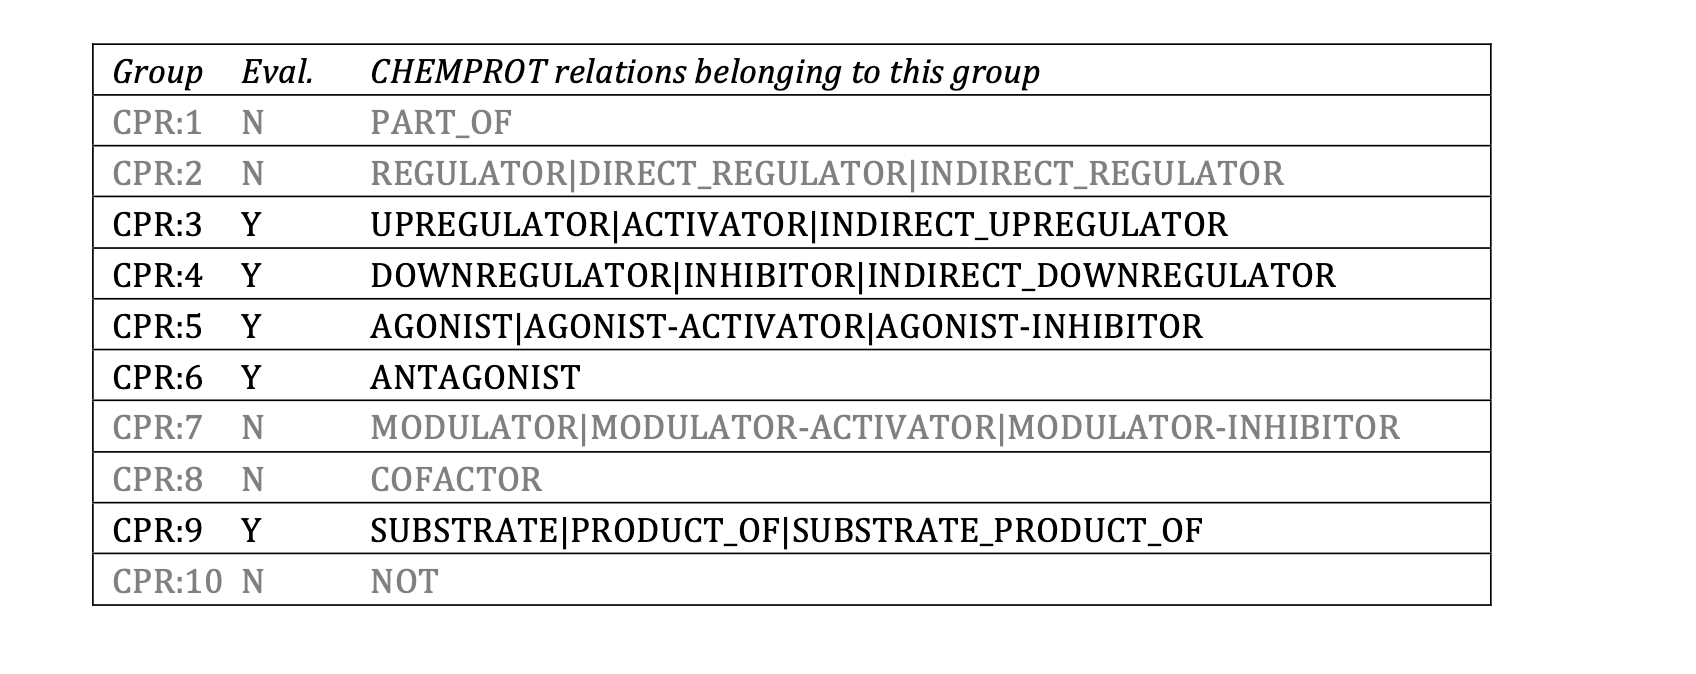

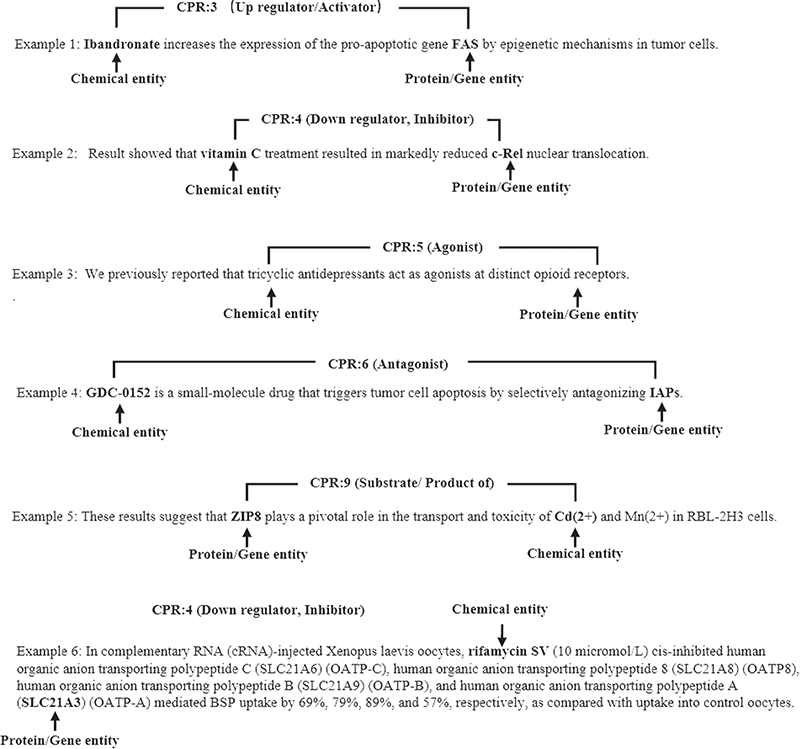

ChemProt RE works well with `ner_chemprot_clinical` find relationships between the following entities

`CHEMICAL`: Chemical entity mention type; 

`GENE-Y`: gene/protein mention type that can be normalized or associated to a biological database identifier; 

`GENE-N`: gene/protein mention type that cannot be normalized to a database identifier. 


In [47]:
ner_tagger = MedicalNerModel()\
    .pretrained("ner_chemprot_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ner_converter = NerConverterInternal() \
    .setInputCols(["sentences", "tokens", "ner_tags"]) \
    .setOutputCol("ner_chunk")

chemprot_re_model = RelationExtractionModel()\
    .pretrained("re_chemprot_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\

chemprot_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_converter,
    dependency_parser,
    chemprot_re_model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chemprot_model = chemprot_pipeline.fit(empty_data)

ner_chemprot_clinical download started this may take some time.
[ | ]ner_chemprot_clinical download started this may take some time.
Approximate size to download 15.3 MB
Download done! Loading the resource.
[ / ]

2022-09-22 11:00:56.251772: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
re_chemprot_clinical download started this may take some time.
Approximate size to download 5.9 MB
[ | ]re_chemprot_clinical download started this may take some time.
Approximate size to download 5.9 MB
Download done! Loading the resource.
[OK!]


In [48]:
text='''
In this study, we examined the effects of mitiglinide on various cloned K(ATP) channels (Kir6.2/SUR1, Kir6.2/SUR2A, and Kir6.2/SUR2B) reconstituted in COS-1 cells, and compared them to another meglitinide-related compound, nateglinide. Patch-clamp analysis using inside-out recording configuration showed that mitiglinide inhibits the Kir6.2/SUR1 channel currents in a dose-dependent manner (IC50 value, 100 nM) but does not significantly inhibit either Kir6.2/SUR2A or Kir6.2/SUR2B channel currents even at high doses (more than 10 microM). Nateglinide inhibits Kir6.2/SUR1 and Kir6.2/SUR2B channels at 100 nM, and inhibits Kir6.2/SUR2A channels at high concentrations (1 microM). Binding experiments on mitiglinide, nateglinide, and repaglinide to SUR1 expressed in COS-1 cells revealed that they inhibit the binding of [3H]glibenclamide to SUR1 (IC50 values: mitiglinide, 280 nM; nateglinide, 8 microM; repaglinide, 1.6 microM), suggesting that they all share a glibenclamide binding site. The insulin responses to glucose, mitiglinide, tolbutamide, and glibenclamide in MIN6 cells after chronic mitiglinide, nateglinide, or repaglinide treatment were comparable to those after chronic tolbutamide and glibenclamide treatment. These results indicate that, similar to the sulfonylureas, mitiglinide is highly specific to the Kir6.2/SUR1 complex, i.e., the pancreatic beta-cell K(ATP) channel, and suggest that mitiglinide may be a clinically useful anti-diabetic drug.
'''
lmodel = LightPipeline(chemprot_model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df[rel_df.entity1!=rel_df.entity2]

relation   entity1 entity1_begin entity1_end             chunk1   entity2  \
0     CPR:2  CHEMICAL            43          53        mitiglinide    GENE-N   
1     CPR:2    GENE-N            80          87           channels  CHEMICAL   
4     CPR:4  CHEMICAL           706         716        mitiglinide    GENE-Y   
6     CPR:2  CHEMICAL           719         729        nateglinide    GENE-Y   
7     CPR:2  CHEMICAL           736         746        repaglinide    GENE-Y   
8     CPR:2  CHEMICAL           823         839  [3H]glibenclamide    GENE-Y   
11    CPR:2    GENE-N           998        1004            insulin  CHEMICAL   
12    CPR:2    GENE-N           998        1004            insulin  CHEMICAL   
13    CPR:3    GENE-N           998        1004            insulin  CHEMICAL   
14    CPR:3    GENE-N           998        1004            insulin  CHEMICAL   
15    CPR:3    GENE-N           998        1004            insulin  CHEMICAL   
34    CPR:4  CHEMICAL          1290        1300        mitiglinide    GENE-N   

   entity2_begin entity2_end         chunk2  confidence  
0             80          87       channels   0.6070414  
1            224         234    nateglinide  0.98933965  
4            751         754           SUR1   0.7594982  
6            751         754           SUR1   0.9999553  
7            751         754           SUR1   0.9919803  
8            844         847           SUR1         1.0  
11          1019        1025        glucose  0.59488183  
12          1028        1038    mitiglinide   0.5599123  
13          1041        1051    tolbutamide  0.98802537  
14          1058        1070  glibenclamide  0.98900056  
15          1100        1110    mitiglinide   0.9898141  
34          1387        1393        channel   0.9894153

# **Train a Custom Relation Extraction Model**

In [49]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/i2b2_clinical_rel_dataset.csv

In [50]:
data = spark.read.option("header","true").format("csv").load("./i2b2_clinical_rel_dataset.csv")

data = data.select( 'sentence','firstCharEnt1','firstCharEnt2','lastCharEnt1','lastCharEnt2', "chunk1", "chunk2", "label1", "label2",'rel','dataset')

data.show(10)

# you only need these columns>> 'sentence','firstCharEnt1','firstCharEnt2','lastCharEnt1','lastCharEnt2', "chunk1", "chunk2", "label1", "label2",'rel'
# ('dataset' column is optional)

+--------------------+-------------+-------------+------------+------------+--------------------+--------------------+---------+---------+-----+-------+
|            sentence|firstCharEnt1|firstCharEnt2|lastCharEnt1|lastCharEnt2|              chunk1|              chunk2|   label1|   label2|  rel|dataset|
+--------------------+-------------+-------------+------------+------------+--------------------+--------------------+---------+---------+-----+-------+
|VITAL SIGNS - Tem...|           49|           75|          64|          84|    respiratory rate|          saturation|     test|     test|    O|   test|
|No lotions , crea...|            3|           34|           9|          42|             lotions|           incisions|treatment|  problem|TrNAP|   test|
|Because of expect...|           11|           58|          54|          68|expected long ter...|         a picc line|treatment|treatment|    O|  train|
|She states this l...|           16|           82|          31|          92|    li

In [51]:
data.groupby('dataset').count().show()

+-------+-----+
|dataset|count|
+-------+-----+
|  train|  350|
|   test|  650|
+-------+-----+



In [52]:
data.groupby('rel').count().show()

+-----+-----+
|  rel|count|
+-----+-----+
| TrIP|   14|
| TrAP|  164|
| TeCP|   26|
|    O|  414|
|TrNAP|   14|
| TrCP|   28|
|  PIP|  153|
| TrWP|   11|
| TeRP|  176|
+-----+-----+



In [53]:
#Annotation structure
annotationType = T.StructType([
            T.StructField('annotatorType', T.StringType(), False),
            T.StructField('begin', T.IntegerType(), False),
            T.StructField('end', T.IntegerType(), False),
            T.StructField('result', T.StringType(), False),
            T.StructField('metadata', T.MapType(T.StringType(), T.StringType()), False),
            T.StructField('embeddings', T.ArrayType(T.FloatType()), False)
        ])

#UDF function to convert train data to names entitities

@F.udf(T.ArrayType(annotationType))
def createTrainAnnotations(begin1, end1, begin2, end2, chunk1, chunk2, label1, label2):
    
    entity1 = sparknlp.annotation.Annotation("chunk", begin1, end1, chunk1, {'entity': label1.upper(), 'sentence': '0'}, [])
    entity2 = sparknlp.annotation.Annotation("chunk", begin2, end2, chunk2, {'entity': label2.upper(), 'sentence': '0'}, [])    
        
    entity1.annotatorType = "chunk"
    entity2.annotatorType = "chunk"

    return [entity1, entity2]    

#list of valid relations
rels = ["TrIP", "TrAP", "TeCP", "TrNAP", "TrCP", "PIP", "TrWP", "TeRP"]

#a query to select list of valid relations
valid_rel_query = "(" + " OR ".join(["rel = '{}'".format(rel) for rel in rels]) + ")"

data = data\
  .withColumn("begin1i", F.expr("cast(firstCharEnt1 AS Int)"))\
  .withColumn("end1i", F.expr("cast(lastCharEnt1 AS Int)"))\
  .withColumn("begin2i", F.expr("cast(firstCharEnt2 AS Int)"))\
  .withColumn("end2i", F.expr("cast(lastCharEnt2 AS Int)"))\
  .where("begin1i IS NOT NULL")\
  .where("end1i IS NOT NULL")\
  .where("begin2i IS NOT NULL")\
  .where("end2i IS NOT NULL")\
  .where(valid_rel_query)\
  .withColumn(
      "train_ner_chunks", 
      createTrainAnnotations(
          "begin1i", "end1i", "begin2i", "end2i", "chunk1", "chunk2", "label1", "label2"
      ).alias("train_ner_chunks", metadata={'annotatorType': "chunk"}))
    

train_data = data.where("dataset='train'")
test_data = data.where("dataset='test'")

### **Create graph** 

We will use TFGraphBuilder annotator which can be used to create graphs automatically in the model training pipeline.

TFGraphBuilder inspects the data and creates the proper graph if a suitable version of TensorFlow is available. The graph is stored in the defined folder and loaded by the approach.

You can also create a custom graph by using tf_graph module in Spark NLP for Healthcare.

In [55]:
from sparknlp_jsl.training import tf_graph

In [56]:
'''
# custom graph

from sparknlp_jsl.training import tf_graph

tf_graph.print_model_params("relation_extraction")

tf_graph.build("relation_extraction", 
             build_params={"input_dim": 10000, 
                          "output_dim": 10, 
                          'batch_norm':1, 
                          "hidden_layers": [300, 200], 
                          "hidden_act": "relu", 
                          'hidden_act_l2':1}, 
                          'model_location'=".", 
                          'model_filename'="re_in6000D_out10.pb")
'''

'''
# ready to use graph
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/generic_classifier_graph/RE_in1200D_out20.pb
'''

'\n# ready to use graph\n!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/generic_classifier_graph/RE_in1200D_out20.pb\n'

In [57]:
from sparknlp_jsl.annotator import TFGraphBuilder

In [87]:
graph_folder= "./tf_graphs"

In [88]:
re_graph_builder = TFGraphBuilder()\
    .setModelName("relation_extraction")\
    .setInputCols(["embeddings", "pos_tags", "train_ner_chunks", "dependencies"]) \
    .setLabelColumn("rel")\
    .setGraphFolder(graph_folder)\
    .setGraphFile("re_graph.pb")\
    .setHiddenLayers([300, 200])\
    .setHiddenAct("relu")\
    .setHiddenActL2(True)\
    .setHiddenWeightsL2(False)\
    .setBatchNorm(False)

In [89]:
documenter = DocumentAssembler()\
    .setInputCol("sentence")\
    .setOutputCol("sentences")

tokenizer = Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")\

words_embedder = WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")
    
dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

# set training params and upload model graph (see ../Healthcare/8.Generic_Classifier.ipynb)
reApproach = RelationExtractionApproach()\
    .setInputCols(["embeddings", "pos_tags", "train_ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setLabelColumn("rel")\
    .setEpochsNumber(70)\
    .setBatchSize(200)\
    .setDropout(0.5)\
    .setLearningRate(0.001)\
    .setModelFile(f"{graph_folder}/re_graph.pb")\
    .setFixImbalance(True)\
    .setFromEntity("begin1i", "end1i", "label1")\
    .setToEntity("begin2i", "end2i", "label2")\
    .setOutputLogsPath('./')

finisher = Finisher()\
    .setInputCols(["relations"])\
    .setOutputCols(["relations_out"])\
    .setCleanAnnotations(False)\
    .setValueSplitSymbol(",")\
    .setAnnotationSplitSymbol(",")\
    .setOutputAsArray(False)

train_pipeline = Pipeline(stages=[
    documenter, 
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    dependency_parser, 
    re_graph_builder,
    reApproach, 
    finisher
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]


In [90]:
%time rel_model = train_pipeline.fit(train_data)

TF Graph Builder configuration:
Model name: relation_extraction
Graph folder: ./tf_graphs
Graph file name: re_graph.pb
Build params: {'input_dim': 1149, 'output_dim': 8, 'hidden_layers': [300, 200], 'hidden_act': 'relu', 'hidden_act_l2': True, 'hidden_weights_l2': False, 'batch_norm': False}
relation_extraction graph exported to ./tf_graphs/re_graph.pb


Training 70 epochs
Epoch 1/70	0.11s	Loss: 0.11508267	ACC: 0.25
Epoch 2/70	0.01s	Loss: 0.13898581	ACC: 0.3475
Epoch 3/70	0.01s	Loss: 0.1939885	ACC: 0.21000001
Epoch 4/70	0.01s	Loss: 0.23352863	ACC: 0.145
Epoch 5/70	0.01s	Loss: 0.11533448	ACC: 0.20750001
Epoch 6/70	0.01s	Loss: 0.08141257	ACC: 0.1875
Epoch 7/70	0.01s	Loss: 0.13308229	ACC: 0.23249999
Epoch 8/70	0.01s	Loss: 0.11574519	ACC: 0.19749999
Epoch 9/70	0.01s	Loss: 0.12328914	ACC: 0.29250002
Epoch 10/70	0.01s	Loss: 0.084303424	ACC: 0.435
Epoch 11/70	0.01s	Loss: 0.098361395	ACC: 0.26500002
Epoch 12/70	0.01s	Loss: 0.07893138	ACC: 0.26500002
Epoch 13/70	0.01s	Loss: 0.09359758	ACC: 0.3375
Epoch 14/70	0.01s	Loss: 0.06849622	ACC: 0.5
Epoch 15/70	0.01s	Loss: 0.11888135	ACC: 0.48250002
Epoch 16/70	0.01s	Loss: 0.1280873	ACC: 0.395
Epoch 17/70	0.01s	Loss: 0.06405215	ACC: 0.41750002
Epoch 18/70	0.01s	Loss: 0.071165025	ACC: 0.405
Epoch 19/70	0.01s	Loss: 0.060132403	ACC: 0.39
Epoch 20/70	0.01s	Loss: 0.070908755	ACC: 0.48250002
Epoch 21/70	0.01s	

In [91]:
rel_model.stages

[DocumentAssembler_b6f65cfe86e3,
 REGEX_TOKENIZER_eb6f0b663e2d,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 POS_6f55785005bf,
 dependency_e7755462ba78,
 TFGraphBuilderModel_825323a456ab,
 RelationExtractionModel_ac19adc2d4ca,
 Finisher_cf318f83318f]

In [92]:
rel_model.stages[-2]

RelationExtractionModel_ac19adc2d4ca

In [93]:
rel_model.stages[-2].write().overwrite().save('custom_RE_model')

In [94]:
result = rel_model.transform(test_data)

In [95]:
recall = result\
    .groupBy("rel")\
    .agg(F.avg(F.expr("IF(rel = relations_out, 1, 0)")).alias("recall"))\
    .select(
        F.col("rel").alias("relation"), 
        F.format_number("recall", 2).alias("recall"))\
    .show()

performance  = result\
    .where("relations_out <> ''")\
    .groupBy("relations_out")\
    .agg(F.avg(F.expr("IF(rel = relations_out, 1, 0)")).alias("precision"))\
    .select(
        F.col("relations_out").alias("relation"), 
        F.format_number("precision", 2).alias("precision"))\
    .show()

+--------+------+
|relation|recall|
+--------+------+
|    TrIP|  0.09|
|    TrAP|  0.46|
|    TeCP|  0.00|
|   TrNAP|  0.00|
|    TrCP|  0.00|
|     PIP|  0.86|
|    TrWP|  0.00|
|    TeRP|  0.56|
+--------+------+



+--------+---------+
|relation|precision|
+--------+---------+
|    TrIP|     1.00|
|    TrAP|     0.76|
|    TeCP|     0.00|
|   TrNAP|     0.00|
|    TrCP|     0.00|
|     PIP|     0.51|
|    TeRP|     0.84|
+--------+---------+



In [96]:
result_df = result.select(F.explode(F.arrays_zip(result.relations.result, 
                                                 result.relations.metadata)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("relation"),
                          F.expr("cols['1']['entity1']").alias("entity1"),
                          F.expr("cols['1']['entity1_begin']").alias("entity1_begin"),
                          F.expr("cols['1']['entity1_end']").alias("entity1_end"),
                          F.expr("cols['1']['chunk1']").alias("chunk1"),
                          F.expr("cols['1']['entity2']").alias("entity2"),
                          F.expr("cols['1']['entity2_begin']").alias("entity2_begin"),
                          F.expr("cols['1']['entity2_end']").alias("entity2_end"),
                          F.expr("cols['1']['chunk2']").alias("chunk2"),
                          F.expr("cols['1']['confidence']").alias("confidence")
                          )

result_df.show(50, truncate=100)



+--------+---------+-------------+-----------+----------------------------------------------------------+---------+-------------+-----------+-----------------------------------------------------------+----------+
|relation|  entity1|entity1_begin|entity1_end|                                                    chunk1|  entity2|entity2_begin|entity2_end|                                                     chunk2|confidence|
+--------+---------+-------------+-----------+----------------------------------------------------------+---------+-------------+-----------+-----------------------------------------------------------+----------+
|     PIP|  PROBLEM|          145|        176|                          1-mm st depressions in i and avl|  PROBLEM|          196|        239|               an inferior and right ventricular infarction| 0.7922303|
|    TeRP|     TEST|            1|         20|                                      abdominal ultrasound|  PROBLEM|           54|         71|       

## **Load trained model from disk**

In [7]:
import pandas as pd

def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result, 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df

In [98]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

clinical_ner_tagger = MedicalNerModel()\
    .pretrained("ner_clinical",'en','clinical/models')\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

loaded_re_Model = RelationExtractionModel()\
    .load("custom_RE_model")\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"]) \
    .setOutputCol("relations")\
    .setRelationPairs(["problem-test", "problem-treatment"])\
    .setPredictionThreshold(0.9)\
    .setMaxSyntacticDistance(4)

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    clinical_ner_tagger,
    ner_chunker,
    dependency_parser,
    loaded_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_clinical download started this may take some time.
[OK!]


In [99]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection. She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""

re_model_light = LightPipeline(model)

annotations = re_model_light.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df

relation    entity1 entity1_begin entity1_end         chunk1  entity2  \
0     TrAP  TREATMENT           507         517    amoxicillin  PROBLEM   
1     TrAP  TREATMENT           593         605  dapagliflozin  PROBLEM   
2     TrAP  TREATMENT           637         647    gemfibrozil  PROBLEM   

  entity2_begin entity2_end                         chunk2  confidence  
0           523         551  a respiratory tract infection   0.9608727  
1           611         614                           T2DM   0.9416355  
2           653         655                            HTG  0.95934194

# **End-to-end trained Models using BioBERT**
#### Latest addition to Spark NLP for Heathcare - (Requires Spark NLP 2.7.3+ and Spark NLP JSL 2.7.3+)

These models are trained as end-to-end bert models using BioBERT and ported in to the Spark NLP ecosystem. 

They offer SOTA performance on most benchmark tasks and outperform our existing Relation Extraction Models.

## ADE ReDL

In [5]:
ner_tagger = MedicalNerModel.pretrained("ner_ade_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")  

ade_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(10)\
    .setRelationPairs(["drug-ade, ade-drug"])

ade_re_model = RelationExtractionDLModel()\
    .pretrained('redl_ade_biobert', 'en', "clinical/models") \
    .setPredictionThreshold(0.5)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

ade_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_chunker,
    dependency_parser,
    ade_re_ner_chunk_filter,
    ade_re_model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ade_model = ade_pipeline.fit(empty_data)

ner_ade_clinical download started this may take some time.
[OK!]
redl_ade_biobert download started this may take some time.
[OK!]


In [8]:
text ="""A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands."""

ade_lmodel = LightPipeline(ade_model)
ade_results = ade_lmodel.fullAnnotate(text)

rel_df = get_relations_df (ade_results)

rel_df

relation entity1 entity1_begin entity1_end     chunk1 entity2 entity2_begin  \
0        1    DRUG            25          32   naproxen     ADE           137   
1        1    DRUG            25          32   naproxen     ADE           154   
2        1    DRUG            87          95  oxaprozin     ADE           137   
3        1    DRUG            87          95  oxaprozin     ADE           154   

  entity2_end                                             chunk2  confidence  
0         148                                       tense bullae   0.9996171  
1         210  cutaneous fragility on the face and the back o...    0.995609  
2         148                                       tense bullae  0.99220794  
3         210  cutaneous fragility on the face and the back o...  0.99784005

## **Clinical ReDL**

In [9]:
clinical_ner_tagger = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

clinical_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(4)\
    .setRelationPairs(["problem-test", "problem-treatment"])# we can set the possible relation pairs (if not set, all the relations will be calculated)
    
clinical_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_clinical_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.9)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    clinical_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_ner_chunk_filter,
    clinical_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_clinical download started this may take some time.
[ | ]ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
Download done! Loading the resource.


2022-09-22 11:41:21.068692: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
redl_clinical_biobert download started this may take some time.
[ | ]redl_clinical_biobert download started this may take some time.
Approximate size to download 383.4 MB
Download done! Loading the resource.
[OK!]


In [10]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""
lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df

relation    entity1 entity1_begin entity1_end                       chunk1  \
0      TrAP  TREATMENT           512         522                  amoxicillin   
1      TrAP  TREATMENT           571         579                    metformin   
2      TrAP  TREATMENT           583         591                    glipizide   
3      TrAP  TREATMENT           599         611                dapagliflozin   
4      TrAP  TREATMENT           599         611                dapagliflozin   
5      TrAP    PROBLEM           617         620                         T2DM   
6      TrAP    PROBLEM           617         620                         T2DM   
7      TrAP  TREATMENT           626         637                 atorvastatin   
8      TrAP  TREATMENT           643         653                  gemfibrozil   
9      TeRP       TEST           739         758         Physical examination   
10     TeRP       TEST           830         854    her abdominal examination   
11     TeRP       TEST           830         854    her abdominal examination   
12     TeRP       TEST           830         854    her abdominal examination   
13     TeRP       TEST          1507        1517                  her glucose   
14     TeRP       TEST          1535        1547                the anion gap   
15     TeRP    PROBLEM          1553        1566               still elevated   
16     TeRP    PROBLEM          1553        1566               still elevated   
17     TeRP       TEST          1676        1702  The β-hydroxybutyrate level   
18     TrAP  TREATMENT          1937        1951              an insulin drip   

      entity2 entity2_begin entity2_end                         chunk2  \
0     PROBLEM           528         556  a respiratory tract infection   
1     PROBLEM           617         620                           T2DM   
2     PROBLEM           617         620                           T2DM   
3     PROBLEM           617         620                           T2DM   
4     PROBLEM           659         661                            HTG   
5   TREATMENT           626         637                   atorvastatin   
6   TREATMENT           643         653                    gemfibrozil   
7     PROBLEM           659         661                            HTG   
8     PROBLEM           659         661                            HTG   
9     PROBLEM           796         810                dry oral mucosa   
10    PROBLEM           875         884                     tenderness   
11    PROBLEM           888         895                       guarding   
12    PROBLEM           902         909                       rigidity   
13    PROBLEM          1553        1566                 still elevated   
14    PROBLEM          1553        1566                 still elevated   
15       TEST          1576        1592              serum bicarbonate   
16       TEST          1670        1672                            U/L   
17    PROBLEM          1733        1740                       elevated   
18    PROBLEM          1957        1961                          euDKA   

    confidence  
0    0.9940485  
1   0.99646974  
2   0.99133927  
3    0.9951285  
4   0.99533916  
5   0.98704636  
6    0.9904655  
7   0.97899765  
8    0.9905245  
9    0.9969105  
10  0.98701364  
11   0.9930791  
12   0.9933403  
13  0.98052305  
14   0.9888292  
15   0.9646118  
16   0.9279459  
17   0.9875728  
18  0.98236454

## **Clinical Temporal Events ReDL**

In [11]:
events_ner_tagger = MedicalNerModel.pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")     

events_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")
    
events_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_temporal_events_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.5)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    events_ner_tagger,
    ner_chunker,
    dependency_parser,
    events_re_ner_chunk_filter,
    events_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_events_clinical download started this may take some time.
[ | ]ner_events_clinical download started this may take some time.
Approximate size to download 13.8 MB
Download done! Loading the resource.


2022-09-22 11:42:18.357465: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
redl_temporal_events_biobert download started this may take some time.
[ | ]redl_temporal_events_biobert download started this may take some time.
Approximate size to download 383.4 MB
Download done! Loading the resource.
[OK!]


In [12]:
text = "The psychology service saw her and diagnosed her with depression. Then she was discharged on 03/02/2018"

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df[(rel_df.relation!="O")&(rel_df.entity1!=rel_df.entity2)]


relation     entity1 entity1_begin entity1_end  \
0   BEFORE  OCCURRENCE             0          29   

                           chunk1  entity2 entity2_begin entity2_end  \
0  The psychology service saw her  PROBLEM            54          63   

       chunk2  confidence  
0  depression    0.548745

In [13]:
text ="""She is admitted to The John Hopkins Hospital 2 days ago with a history of gestational diabetes mellitus diagnosed.  
She was seen by the endocrinology service and she was discharged on 03/02/2018 on 40 units of insulin glargine, 
12 units of insulin lispro, and metformin 1000 mg two times a day. She had close follow-up with endocrinology post discharge. 
"""

annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df[(rel_df.relation!="O")]


relation        entity1 entity1_begin entity1_end  \
0     AFTER     OCCURRENCE             7          14   
1    BEFORE     OCCURRENCE             7          14   
2    BEFORE     OCCURRENCE             7          14   
3   OVERLAP  CLINICAL_DEPT            19          43   
4    BEFORE  CLINICAL_DEPT            19          43   
5    BEFORE           DATE            45          54   
6    BEFORE  CLINICAL_DEPT           133         157   
7   OVERLAP  CLINICAL_DEPT           133         157   
8   OVERLAP  CLINICAL_DEPT           133         157   
9   OVERLAP  CLINICAL_DEPT           133         157   
10  OVERLAP  CLINICAL_DEPT           133         157   
11  OVERLAP  CLINICAL_DEPT           133         157   
12  OVERLAP     OCCURRENCE           171         180   
13   BEFORE     OCCURRENCE           171         180   
14   BEFORE     OCCURRENCE           171         180   
15   BEFORE     OCCURRENCE           171         180   
16   BEFORE     OCCURRENCE           171         180   
17  OVERLAP           DATE           185         194   
18  OVERLAP           DATE           185         194   
19  OVERLAP           DATE           185         194   
20  OVERLAP           DATE           185         194   
21  OVERLAP      TREATMENT           211         226   
22  OVERLAP      TREATMENT           211         226   
23  OVERLAP      TREATMENT           211         226   
24  OVERLAP      TREATMENT           242         255   
25  OVERLAP      TREATMENT           242         255   
26  OVERLAP      TREATMENT           262         270   

                       chunk1        entity2 entity2_begin entity2_end  \
0                    admitted  CLINICAL_DEPT            19          43   
1                    admitted           DATE            45          54   
2                    admitted        PROBLEM            74         102   
3   The John Hopkins Hospital           DATE            45          54   
4   The John Hopkins Hospital        PROBLEM            74         102   
5                  2 days ago        PROBLEM            74         102   
6   the endocrinology service     OCCURRENCE           171         180   
7   the endocrinology service           DATE           185         194   
8   the endocrinology service      TREATMENT           211         226   
9   the endocrinology service      TREATMENT           242         255   
10  the endocrinology service      TREATMENT           262         270   
11  the endocrinology service      FREQUENCY           280         294   
12                 discharged           DATE           185         194   
13                 discharged      TREATMENT           211         226   
14                 discharged      TREATMENT           242         255   
15                 discharged      TREATMENT           262         270   
16                 discharged      FREQUENCY           280         294   
17                 03/02/2018      TREATMENT           211         226   
18                 03/02/2018      TREATMENT           242         255   
19                 03/02/2018      TREATMENT           262         270   
20                 03/02/2018      FREQUENCY           280         294   
21           insulin glargine      TREATMENT           242         255   
22           insulin glargine      TREATMENT           262         270   
23           insulin glargine      FREQUENCY           280         294   
24             insulin lispro      TREATMENT           262         270   
25             insulin lispro      FREQUENCY           280         294   
26                  metformin      FREQUENCY           280         294   

                           chunk2  confidence  
0       The John Hopkins Hospital    0.852281  
1                      2 days ago    0.572004  
2   gestational diabetes mellitus    0.826807  
3                      2 days ago    0.709595  
4   gestational diabetes mellitus    0.575382  
5   gestational diabetes mellitus    0.594495  
6                      di

## **Human Phenotype - Gene ReDL**

In [14]:
pgr_ner_tagger = MedicalNerModel.pretrained("ner_human_phenotype_gene_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

pgr_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(4)
    
pgr_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_human_phenotype_gene_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.5)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    pgr_ner_tagger,
    ner_chunker,
    dependency_parser,
    pgr_re_ner_chunk_filter,
    pgr_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_human_phenotype_gene_clinical download started this may take some time.
[ | ]ner_human_phenotype_gene_clinical download started this may take some time.
Approximate size to download 14 MB
Download done! Loading the resource.


2022-09-22 11:44:05.620920: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
redl_human_phenotype_gene_biobert download started this may take some time.
[ | ]redl_human_phenotype_gene_biobert download started this may take some time.
Approximate size to download 383.4 MB
Download done! Loading the resource.
[OK!]


In [15]:
text = "She has a retinal degeneration, hearing loss and renal failure, short stature, \
Mutations in the SH3PXD2B gene coding for the Tks4 protein are responsible for the autosomal recessive."

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!=0)]

rel_df

relation entity1 entity1_begin entity1_end                chunk1 entity2  \
0         0      HP            10          29  retinal degeneration      HP   
1         0      HP            10          29  retinal degeneration      HP   
2         0      HP            10          29  retinal degeneration      HP   
3         0      HP            32          43          hearing loss      HP   
4         0      HP            32          43          hearing loss      HP   
5         1      HP            32          43          hearing loss    GENE   
6         1      HP            32          43          hearing loss      HP   
7         0      HP            49          61         renal failure      HP   
8         1      HP            49          61         renal failure    GENE   
9         1      HP            49          61         renal failure      HP   
10        1      HP            64          76         short stature    GENE   

   entity2_begin entity2_end               chunk2  confidence  
0             32          43         hearing loss   0.9333181  
1             49          61        renal failure    0.943889  
2            162         180  autosomal recessive  0.57079256  
3             49          61        renal failure   0.9595531  
4             64          76        short stature   0.7913254  
5             96         103             SH3PXD2B  0.78811955  
6            162         180  autosomal recessive  0.87494564  
7             64          76        short stature   0.9054082  
8             96         103             SH3PXD2B   0.6548081  
9            162         180  autosomal recessive  0.81171495  
10            96         103             SH3PXD2B  0.80119324

## **Drug-Drug Interaction ReDL**

In [16]:
ddi_ner_tagger = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ddi_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(4)
    
ddi_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_drug_drug_interaction_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.9)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ddi_ner_tagger,
    ner_chunker,
    dependency_parser,
    ddi_re_ner_chunk_filter,
    ddi_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_posology download started this may take some time.
[OK!]
redl_drug_drug_interaction_biobert download started this may take some time.
[ | ]redl_drug_drug_interaction_biobert download started this may take some time.
Approximate size to download 383.4 MB
Download done! Loading the resource.
[OK!]


In [17]:
text='When carbamazepine is withdrawn from the combination therapy, aripiprazole dose should then be reduced. \
If additional adrenergic drugs are to be administered by any route, \
they should be used with caution because the pharmacologically predictable sympathetic effects of Metformin may be potentiated'

lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df

relation entity1 entity1_begin entity1_end         chunk1 entity2  \
0  DDI-false    DRUG             5          17  carbamazepine    DRUG   

  entity2_begin entity2_end        chunk2 confidence  
0            62          73  aripiprazole  0.9286566

## **Drug-Protein Interaction ReDL**

In [18]:
drugprot_ner_tagger = MedicalNerModel.pretrained("ner_drugprot_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ner_converter = NerConverter()\
    .setInputCols(["sentences", "tokens", "ner_tags"])\
    .setOutputCol("ner_chunks")

# Set a filter on pairs of named entities which will be treated as relation candidates
drugprot_re_ner_chunk_filter = RENerChunksFilter()\
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(4)\
   .setRelationPairs(["checmical-gene", "chemical-gene_and_chemical", "gene_and_chemical-gene"])
    
drugprot_re_Model = RelationExtractionDLModel()\
    .pretrained('redl_drugprot_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.9)\
    .setInputCols(["re_ner_chunks", "sentences"])\
    .setOutputCol("relations")

pipeline = Pipeline(stages=[documenter, sentencer, tokenizer, words_embedder, drugprot_ner_tagger, ner_converter, pos_tagger, dependency_parser, drugprot_re_ner_chunk_filter, drugprot_re_Model])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

ner_drugprot_clinical download started this may take some time.
[ | ]ner_drugprot_clinical download started this may take some time.
Approximate size to download 14 MB
Download done! Loading the resource.
[ / ]

2022-09-22 11:44:40.401783: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
AddV2: CPU 
Unique: CPU 
Mul: CPU 
VariableV2: CPU 
Assign: CPU 
Shape: CPU 
Identity: CPU 
Cast: CPU 
Sub: CPU 
GatherV2: CPU

[OK!]
redl_drugprot_biobert download started this may take some time.
[ | ]redl_drugprot_biobert download started this may take some time.
Approximate size to download 386.6 MB
Download done! Loading the resource.
[OK!]


In [19]:
text='''Lipid specific activation of the murine P4-ATPase Atp8a1 (ATPase II). The asymmetric transbilayer distribution of phosphatidylserine (PS) in the mammalian plasma membrane and secretory vesicles is maintained, in part, by an ATP-dependent transporter. This aminophospholipid "flippase" selectively transports PS to the cytosolic leaflet of the bilayer and is sensitive to vanadate, Ca(2+), and modification by sulfhydryl reagents. Although the flippase has not been positively identified, a subfamily of P-type ATPases has been proposed to function as transporters of amphipaths, including PS and other phospholipids. A candidate PS flippase ATP8A1 (ATPase II), originally isolated from bovine secretory vesicles, is a member of this subfamily based on sequence homology to the founding member of the subfamily, the yeast protein Drs2, which has been linked to ribosomal assembly, the formation of Golgi-coated vesicles, and the maintenance of PS asymmetry. To determine if ATP8A1 has biochemical characteristics consistent with a PS flippase, a murine homologue of this enzyme was expressed in insect cells and purified. The purified Atp8a1 is inactive in detergent micelles or in micelles containing phosphatidylcholine, phosphatidic acid, or phosphatidylinositol, is minimally activated by phosphatidylglycerol or phosphatidylethanolamine (PE), and is maximally activated by PS. The selectivity for PS is dependent upon multiple elements of the lipid structure. Similar to the plasma membrane PS transporter, Atp8a1 is activated only by the naturally occurring sn-1,2-glycerol isomer of PS and not the sn-2,3-glycerol stereoisomer. Both flippase and Atp8a1 activities are insensitive to the stereochemistry of the serine headgroup. Most modifications of the PS headgroup structure decrease recognition by the plasma membrane PS flippase. Activation of Atp8a1 is also reduced by these modifications; phosphatidylserine-O-methyl ester, lysophosphatidylserine, glycerophosphoserine, and phosphoserine, which are not transported by the plasma membrane flippase, do not activate Atp8a1. Weakly translocated lipids (PE, phosphatidylhydroxypropionate, and phosphatidylhomoserine) are also weak Atp8a1 activators. However, N-methyl-phosphatidylserine, which is transported by the plasma membrane flippase at a rate equivalent to PS, is incapable of activating Atp8a1 activity. These results indicate that the ATPase activity of the secretory granule Atp8a1 is activated by phospholipids binding to a specific site whose properties (PS selectivity, dependence upon glycerol but not serine, stereochemistry, and vanadate sensitivity) are similar to, but distinct from, the properties of the substrate binding site of the plasma membrane flippase.'''

lmodel = LightPipeline(model)

results = lmodel.fullAnnotate(text)

In [20]:
results[0].keys()

dict_keys(['sentences', 'document', 'ner_chunks', 'ner_tags', 'relations', 'tokens', 'embeddings', 'pos_tags', 're_ner_chunks', 'dependencies'])

In [21]:
results[0]["ner_chunks"]

[Annotation(chunk, 33, 48, murine P4-ATPase, {'entity': 'GENE', 'sentence': '0', 'chunk': '0', 'confidence': '0.75505'}),
 Annotation(chunk, 50, 55, Atp8a1, {'entity': 'GENE', 'sentence': '0', 'chunk': '1', 'confidence': '0.9911'}),
 Annotation(chunk, 58, 66, ATPase II, {'entity': 'GENE', 'sentence': '0', 'chunk': '2', 'confidence': '0.8749'}),
 Annotation(chunk, 114, 131, phosphatidylserine, {'entity': 'CHEMICAL', 'sentence': '1', 'chunk': '3', 'confidence': '0.9794'}),
 Annotation(chunk, 134, 135, PS, {'entity': 'CHEMICAL', 'sentence': '1', 'chunk': '4', 'confidence': '0.7845'}),
 Annotation(chunk, 224, 248, ATP-dependent transporter, {'entity': 'GENE_AND_CHEMICAL', 'sentence': '1', 'chunk': '5', 'confidence': '0.77744997'}),
 Annotation(chunk, 256, 282, aminophospholipid "flippase, {'entity': 'GENE_AND_CHEMICAL', 'sentence': '2', 'chunk': '6', 'confidence': '0.59896666'}),
 Annotation(chunk, 308, 309, PS, {'entity': 'CHEMICAL', 'sentence': '2', 'chunk': '7', 'confidence': '0.4899'})

In [22]:
results[0]["relations"]

[Annotation(category, 114, 248, SUBSTRATE, {'chunk2': 'ATP-dependent transporter', 'confidence': '0.9936454', 'entity2_end': '248', 'syntactic_distance': '3', 'chunk1': 'phosphatidylserine', 'entity2_begin': '224', 'entity1': 'CHEMICAL', 'entity1_begin': '114', 'entity1_end': '131', 'context': 'The asymmetric transbilayer distribution of phosphatidylserine (PS) in the mammalian plasma membrane and secretory vesicles is maintained, in part, by an ATP-dependent transporter.', 'entity2': 'GENE_AND_CHEMICAL'}),
 Annotation(category, 134, 248, SUBSTRATE, {'chunk2': 'ATP-dependent transporter', 'confidence': '0.99649626', 'entity2_end': '248', 'syntactic_distance': '4', 'chunk1': 'PS', 'entity2_begin': '224', 'entity1': 'CHEMICAL', 'entity1_begin': '134', 'entity1_end': '135', 'context': 'The asymmetric transbilayer distribution of phosphatidylserine (PS) in the mammalian plasma membrane and secretory vesicles is maintained, in part, by an ATP-dependent transporter.', 'entity2': 'GENE_AND_CH

In [23]:
rel_df = get_relations_df (results)

rel_df

relation            entity1 entity1_begin entity1_end  \
0  SUBSTRATE           CHEMICAL           114         131   
1  SUBSTRATE           CHEMICAL           134         135   
2  SUBSTRATE  GENE_AND_CHEMICAL           256         282   

                        chunk1            entity2 entity2_begin entity2_end  \
0           phosphatidylserine  GENE_AND_CHEMICAL           224         248   
1                           PS  GENE_AND_CHEMICAL           224         248   
2  aminophospholipid "flippase           CHEMICAL           308         309   

                      chunk2  confidence  
0  ATP-dependent transporter   0.9936454  
1  ATP-dependent transporter  0.99649626  
2                         PS  0.99559456

## **Chemical–Protein Interactions (ChemProt) ReDL**

In [5]:
chemprot_ner_tagger = MedicalNerModel.pretrained("ner_chemprot_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

chemprot_re_ner_chunk_filter = RENerChunksFilter() \
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setMaxSyntacticDistance(4)
    
chemprot_re_Model = RelationExtractionDLModel() \
    .pretrained('redl_chemprot_biobert', "en", "clinical/models")\
    .setPredictionThreshold(0.9)\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    chemprot_ner_tagger,
    ner_chunker,
    dependency_parser,
    chemprot_re_ner_chunk_filter,
    chemprot_re_Model
])


empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

ner_chemprot_clinical download started this may take some time.
[OK!]
redl_chemprot_biobert download started this may take some time.
[OK!]


In [8]:
text='''
In this study, we examined the effects of mitiglinide on various cloned K(ATP) channels (Kir6.2/SUR1, Kir6.2/SUR2A, and Kir6.2/SUR2B) reconstituted in COS-1 cells, and compared them to another meglitinide-related compound, nateglinide. Patch-clamp analysis using inside-out recording configuration showed that mitiglinide inhibits the Kir6.2/SUR1 channel currents in a dose-dependent manner (IC50 value, 100 nM) but does not significantly inhibit either Kir6.2/SUR2A or Kir6.2/SUR2B channel currents even at high doses (more than 10 microM). Nateglinide inhibits Kir6.2/SUR1 and Kir6.2/SUR2B channels at 100 nM, and inhibits Kir6.2/SUR2A channels at high concentrations (1 microM). Binding experiments on mitiglinide, nateglinide, and repaglinide to SUR1 expressed in COS-1 cells revealed that they inhibit the binding of [3H]glibenclamide to SUR1 (IC50 values: mitiglinide, 280 nM; nateglinide, 8 microM; repaglinide, 1.6 microM), suggesting that they all share a glibenclamide binding site. The insulin responses to glucose, mitiglinide, tolbutamide, and glibenclamide in MIN6 cells after chronic mitiglinide, nateglinide, or repaglinide treatment were comparable to those after chronic tolbutamide and glibenclamide treatment. These results indicate that, similar to the sulfonylureas, mitiglinide is highly specific to the Kir6.2/SUR1 complex, i.e., the pancreatic beta-cell K(ATP) channel, and suggest that mitiglinide may be a clinically useful anti-diabetic drug.
'''
lmodel = LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df[rel_df.entity1!=rel_df.entity2]

relation   entity1 entity1_begin entity1_end             chunk1   entity2  \
0     CPR:2  CHEMICAL            43          53        mitiglinide    GENE-N   
1     CPR:2    GENE-N            80          87           channels  CHEMICAL   
4     CPR:2  CHEMICAL           706         716        mitiglinide    GENE-Y   
6     CPR:2  CHEMICAL           719         729        nateglinide    GENE-Y   
7     CPR:2  CHEMICAL           736         746        repaglinide    GENE-Y   
8     CPR:2  CHEMICAL           823         839  [3H]glibenclamide    GENE-Y   
11    CPR:2    GENE-N           998        1004            insulin  CHEMICAL   
12    CPR:2    GENE-N           998        1004            insulin  CHEMICAL   
13    CPR:2    GENE-N           998        1004            insulin  CHEMICAL   
14    CPR:2    GENE-N           998        1004            insulin  CHEMICAL   
15    CPR:2    GENE-N           998        1004            insulin  CHEMICAL   
35    CPR:2  CHEMICAL          1290        1300        mitiglinide    GENE-N   

   entity2_begin entity2_end         chunk2  confidence  
0             80          87       channels  0.99909186  
1            224         234    nateglinide    0.995184  
4            751         754           SUR1  0.99832505  
6            751         754           SUR1   0.9986958  
7            751         754           SUR1  0.99847454  
8            844         847           SUR1   0.9994306  
11          1019        1025        glucose   0.9830624  
12          1028        1038    mitiglinide  0.99298626  
13          1041        1051    tolbutamide   0.9787248  
14          1058        1070  glibenclamide   0.9744869  
15          1100        1110    mitiglinide    0.987948  
35          1387        1393        channel   0.9849148

# **Merging Multiple RE Model Results**

We can merge multiple RE model results by using `AnnotationMerger()`. <br/>
Now, we will build a pipeline consisting of `posology_re`, `re_ade_clinical` models and `AnnotationMerger()` to merge these RE models' results. 

In [9]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")

words_embedder = WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")

pos_ner_tagger = MedicalNerModel()\
    .pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_pos")

pos_ner_chunker = NerConverterInternal()\
    .setInputCols(["sentences", "tokens", "ner_pos"])\
    .setOutputCol("pos_ner_chunks")

dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

pos_reModel = RelationExtractionModel()\
    .pretrained("posology_re")\
    .setInputCols(["embeddings", "pos_tags", "pos_ner_chunks", "dependencies"])\
    .setOutputCol("pos_relations")\
    .setMaxSyntacticDistance(4)

ade_ner_tagger = MedicalNerModel.pretrained("ner_ade_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ade_ner_tags")  

ade_ner_chunker = NerConverterInternal()\
    .setInputCols(["sentences", "tokens", "ade_ner_tags"])\
    .setOutputCol("ade_ner_chunks")

ade_reModel = RelationExtractionModel()\
    .pretrained("re_ade_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ade_ner_chunks", "dependencies"])\
    .setOutputCol("ade_relations")\
    .setMaxSyntacticDistance(10)\
    .setRelationPairs(["drug-ade, ade-drug"])

annotation_merger = AnnotationMerger()\
    .setInputCols("ade_relations", "pos_relations")\
    .setInputType("category")\
    .setOutputCol("all_relations")

merger_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    pos_ner_tagger,
    pos_ner_chunker,
    dependency_parser,
    pos_reModel,
    ade_ner_tagger,
    ade_ner_chunker,
    ade_reModel,
    annotation_merger
])

empty_df= spark.createDataFrame([[""]]).toDF("text")
merger_model= merger_pipeline.fit(empty_df)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
ner_posology download started this may take some time.
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
ner_ade_clinical download started this may take some time.
[ | ]ner_ade_clinical download started this may take some time.
Approximate size to download 13.9 MB
Download done! Loading the resource.


2022-09-22 11:49:52.520874: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]
re_ade_clinical download started this may take some time.
Approximate size to download 10.9 MB
[ | ]re_ade_clinical download started this may take some time.
Approximate size to download 10.9 MB
Download done! Loading the resource.
[OK!]


In [10]:
text = """
The patient was prescribed 1 unit of naproxen for 5 days after meals for chronic low back pain. The patient was also given 1 unit of oxaprozin daily for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands.. 
"""
data = spark.createDataFrame([[text]]).toDF("text")

result = merger_model.transform(data)
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|           sentences|              tokens|          embeddings|            pos_tags|             ner_pos|      pos_ner_chunks|        dependencies|       pos_relations|        ade_ner_tags|      ade_ner_chunks|       ade_relations|       all_relations|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|
The patient was ...|[{document, 0, 26...|[{document, 1, 95...|[{token, 1, 3, Th...|[{word_embeddings...|[{pos,

In [11]:
from pyspark.sql import functions as F

result_df = result.select(F.explode(F.arrays_zip(result.pos_relations.result, 
                                                 result.pos_relations.metadata,
                                                 result.ade_relations.result, 
                                                 result.ade_relations.metadata,
                                                 result.all_relations.result, 
                                                 result.all_relations.metadata)).alias("cols")) \
                  .select(
                          F.expr("cols['0']").alias("pos_relations"),\
                          F.expr("cols['1']['entity1']").alias("pos_relations_entity1"),\
                          F.expr("cols['1']['chunk1']" ).alias("pos_relations_chunk1" ),\
                          F.expr("cols['1']['entity2']").alias("pos_relations_entity2"),\
                          F.expr("cols['1']['chunk2']" ).alias("pos_relations_chunk2" ),\
                          F.expr("cols['2']").alias("ade_relations"),\
                          F.expr("cols['3']['entity1']").alias("ade_relations_entity1"),\
                          F.expr("cols['3']['chunk1']" ).alias("ade_relations_chunk1" ),\
                          F.expr("cols['3']['entity2']").alias("ade_relations_entity2"),\
                          F.expr("cols['3']['chunk2']" ).alias("ade_relations_chunk2" ),\
                          F.expr("cols['4']").alias("all_relations"),\
                          F.expr("cols['5']['entity1']").alias("all_relations_entity1"),\
                          F.expr("cols['5']['chunk1']" ).alias("all_relations_chunk1" ),\
                          F.expr("cols['5']['entity2']").alias("all_relations_entity2"),\
                          F.expr("cols['5']['chunk2']" ).alias("all_relations_chunk2" )
                          )

result_df.show()

+--------------+---------------------+--------------------+---------------------+--------------------+-------------+---------------------+--------------------+---------------------+--------------------+--------------+---------------------+--------------------+---------------------+--------------------+
| pos_relations|pos_relations_entity1|pos_relations_chunk1|pos_relations_entity2|pos_relations_chunk2|ade_relations|ade_relations_entity1|ade_relations_chunk1|ade_relations_entity2|ade_relations_chunk2| all_relations|all_relations_entity1|all_relations_chunk1|all_relations_entity2|all_relations_chunk2|
+--------------+---------------------+--------------------+---------------------+--------------------+-------------+---------------------+--------------------+---------------------+--------------------+--------------+---------------------+--------------------+---------------------+--------------------+
|   DOSAGE-DRUG|               DOSAGE|              1 unit|                 DRUG|       

Now, we will build a LightPipeline and visualize the results by using `RelationExtractionVisualizer`

In [12]:
lp_merger = LightPipeline(merger_model)
lp_res = lp_merger.fullAnnotate(text)[0]

In [13]:
from sparknlp_display import RelationExtractionVisualizer

In [14]:
vis= RelationExtractionVisualizer()
vis.display(lp_res, 'all_relations', show_relations=True)

# **Clinical Knowledge Graph Creation using Neo4j**

We have recently published a [Medium article](https://medium.com/spark-nlp/creating-knowledge-graph-by-spark-nlp-neo4j-9d18706aa08b) explains "How to create a  clinical knowledge graph using Spark NLP and Neo4j." and for detailed information, you can play with [the notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/10.2.Clinical_RE_Knowledge_Graph_with_Neo4j.ipynb). Briefly, in this article, we built a Knowledge Graph (KG) using Spark NLP Relation Extraction (RE) Models and Neo4j. Some of the Spark NLP users ask "How can I use the RE results?". First, you can use the results to feed downstream pipelines. Secondly, you can create a KG to try to get insights. The article explains how to accomplish the second option. Here are some snapshots:

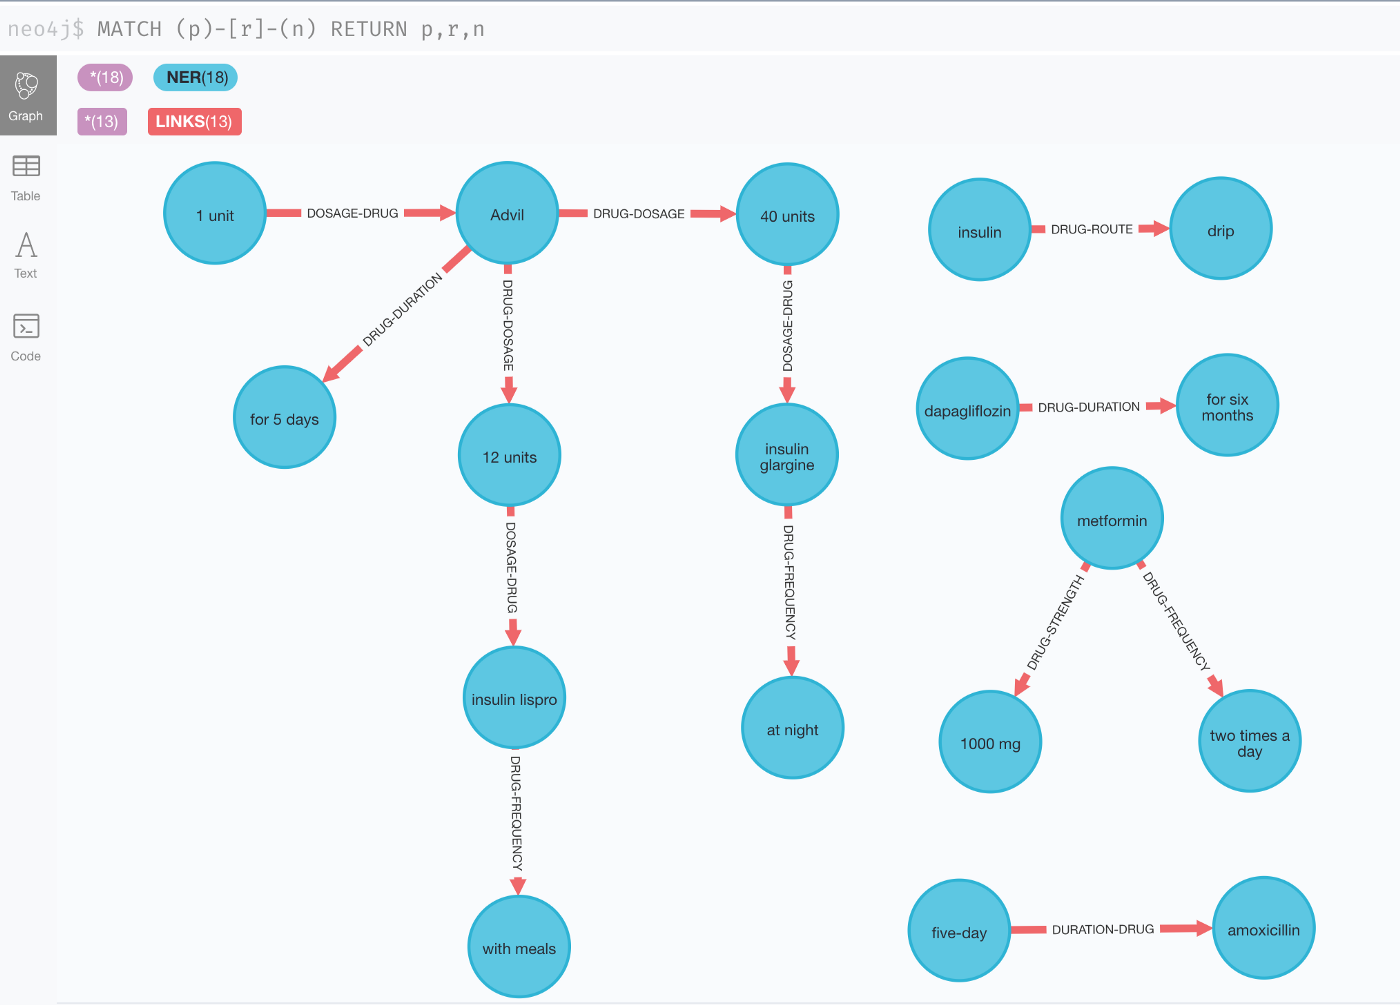

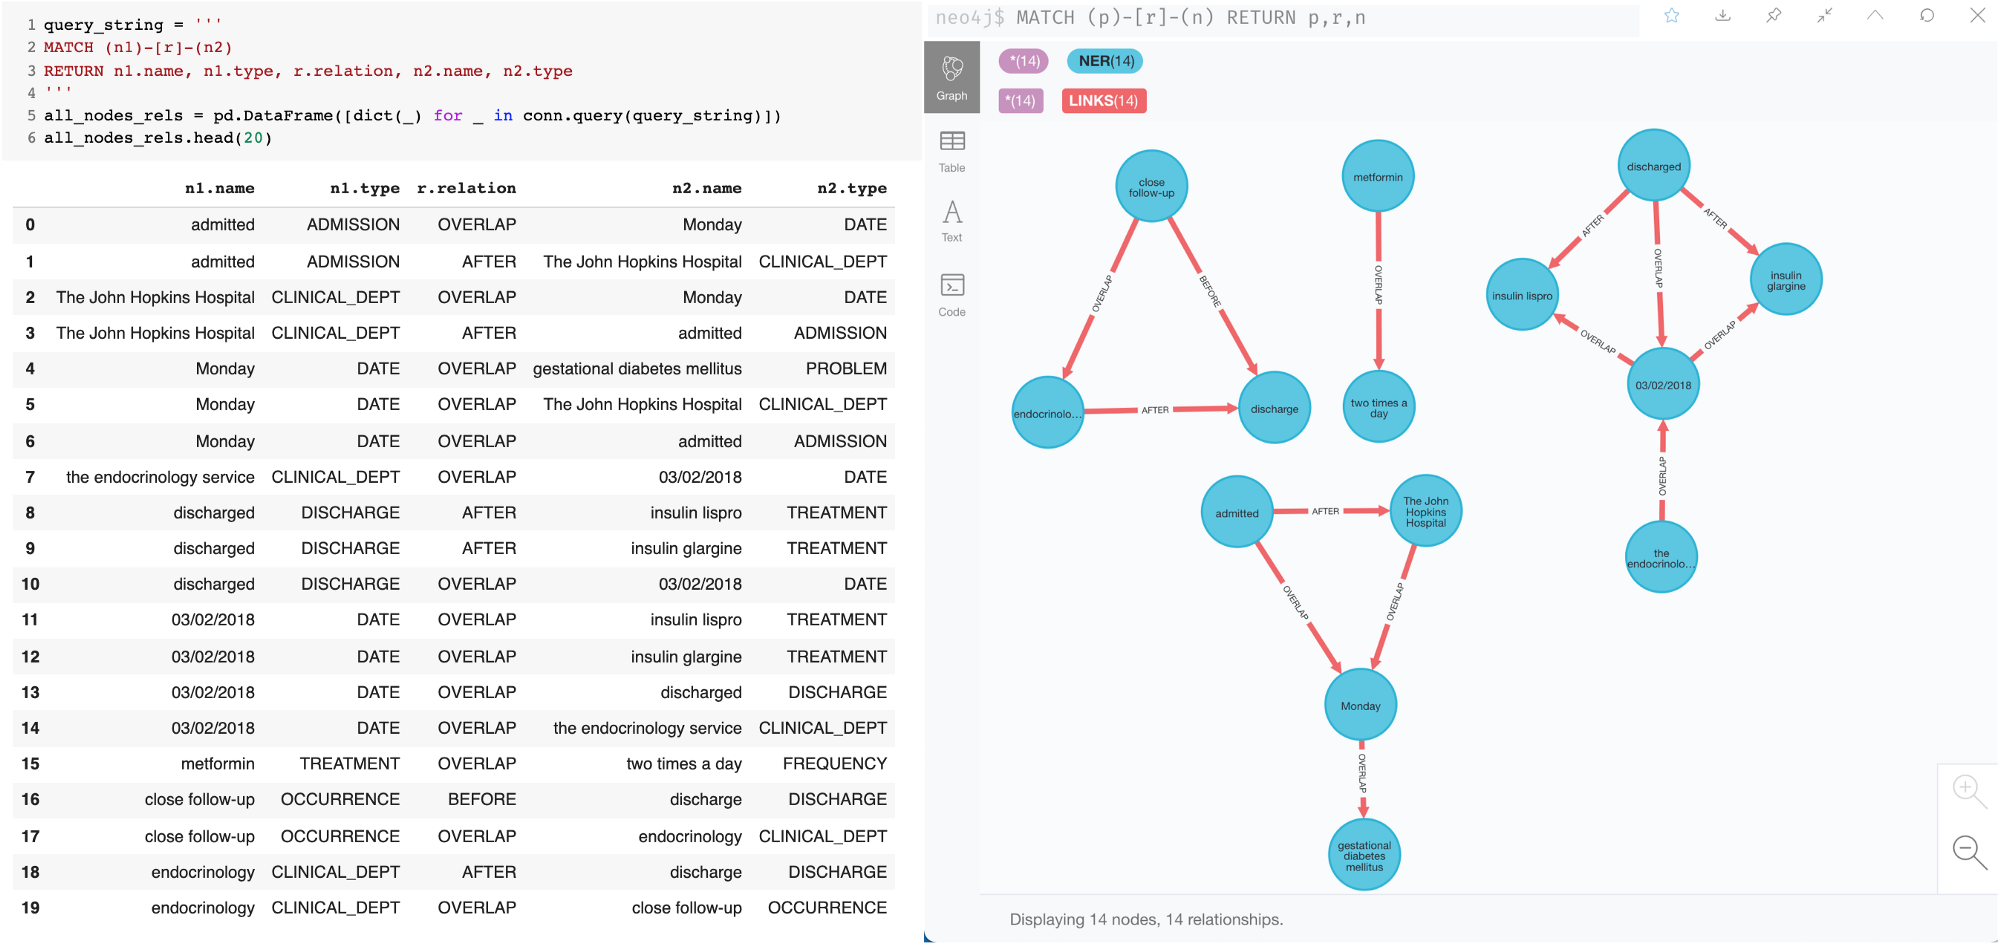

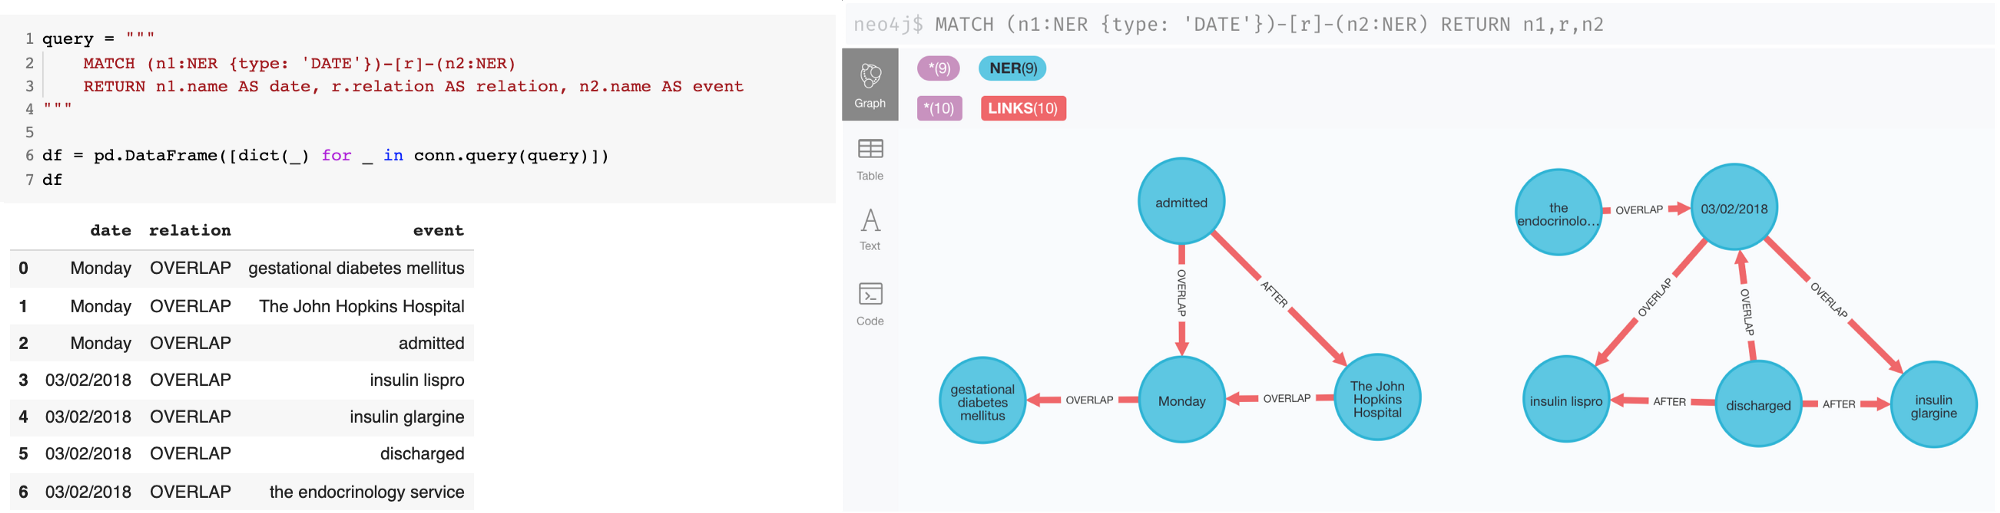

# Relation Extraction Model-NER Model-Relation Pairs Table

In the table below, you can find the Relationship Extraction models and the most appropriate NER models and Relationship Pairs that can be used to get the most efficient results when using these models.

|    | RELATION EXTRACTION MODEL            | RELATION EXTRACTION MODEL LABELS                                        | NER MODEL                         | RELATION PAIRS                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|---:|:-------------------------------------|:------------------------------------------------------------------------|:----------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | re_bodypart_proceduretest            | 0-1                                                                     | ner_jsl                           | ["external_body_part_or_region-test", <br/> "test-external_body_part_or_region",<br/>"internal_organ_or_component-test",<br/>"test-internal_organ_or_component",<br/>"external_body_part_or_region-procedure",<br/>"procedure-external_body_part_or_region",<br/>"procedure-internal_organ_or_component",<br/>"internal_organ_or_component-procedure"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|  1 | re_ade_clinical                      | 0-1                                                                     | ner_ade_clinical                  | ["ade-drug",<br/> "drug-ade"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|  2 | redl_chemprot_biobert                | CPR:1, CPR:2, CPR:3, CPR:4, CPR:5, CPR:6, CPR:7, CPR:8, CPR:9, CPR:10   | ner_chemprot_clinical             |   No need to set pairs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|  3 | re_human_phenotype_gene_clinical     | 0-1                                                                     | ner_human_phenotype_gene_clinical |   No need to set pairs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|  4 | re_bodypart_directions               | 0-1                                                                     | ner_jsl                           | ["direction-external_body_part_or_region",<br/>"external_body_part_or_region-direction",<br/>"direction-internal_organ_or_component",<br/>"internal_organ_or_component-direction"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
|  5 | re_bodypart_problem                  | 0-1                                                                     | ner_jsl                           | ["internal_organ_or_component-cerebrovascular_disease", "cerebrovascular_disease-internal_organ_or_component",<br/>"internal_organ_or_component-communicable_disease", "communicable_disease-internal_organ_or_component",<br/>"internal_organ_or_component-diabetes", "diabetes-internal_organ_or_component",<br/>"internal_organ_or_component-disease_syndrome_disorder", "disease_syndrome_disorder-internal_organ_or_component",<br/>"internal_organ_or_component-ekg_findings", "ekg_findings-internal_organ_or_component",<br/>"internal_organ_or_component-heart_disease", "heart_disease-internal_organ_or_component",<br/>"internal_organ_or_component-hyperlipidemia", "hyperlipidemia-internal_organ_or_component",<br/>"internal_organ_or_component-hypertension", "hypertension-internal_organ_or_component",<br/>"internal_organ_or_component-imagingfindings", "imagingfindings-internal_organ_or_component",<br/>"internal_organ_or_component-injury_or_poisoning", "injury_or_poisoning-internal_organ_or_component",<br/>"internal_organ_or_component-kidney_disease", "kidney_disease-internal_organ_or_component",<br/>"internal_organ_or_component-oncological", "oncological-internal_organ_or_component",<br/>"internal_organ_or_component-psychological_condition", "psychological_condition-internal_organ_or_component",<br/>"internal_organ_or_component-symptom", "symptom-internal_organ_or_component",<br/>"internal_organ_or_component-vs_finding", "vs_finding-internal_organ_or_component",<br/>"external_body_part_or_region-communicable_disease", "communicable_disease-external_body_part_or_region",<br/>"external_body_part_or_region-diabetes", "diabetes-external_body_part_or_region",<br/>"external_body_part_or_region-disease_syndrome_disorder", "disease_syndrome_disorder-external_body_part_or_region",<br/>"external_body_part_or_region-hypertension", "hypertension-external_body_part_or_region",<br/>"external_body_part_or_region-imagingfindings", "imagingfindings-external_body_part_or_region",<br/>"external_body_part_or_region-injury_or_poisoning", "injury_or_poisoning-external_body_part_or_region",<br/>"external_body_part_or_region-obesity", "obesity-external_body_part_or_region",<br/>"external_body_part_or_region-oncological", "oncological-external_body_part_or_region",<br/>"external_body_part_or_region-overweight", "overweight-external_body_part_or_region",<br/>"external_body_part_or_region-symptom", "symptom-external_body_part_or_region",<br/>"external_body_part_or_region-vs_finding", "vs_finding-external_body_part_or_region"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|  6 | re_drug_drug_interaction_clinical    | DDI-advise, DDI-effect, DDI-mechanism, DDI-int, DDI-false               | ner_posology                      | ["drug-drug"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|  7 | re_clinical                          | TrIP, TrWP, TrCP, TrAP, TrAP, TeRP, TeCP, PIP                           | ner_clinical                      |   No need to set pairs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|  8 | re_temporal_events_clinical          | AFTER, BEFORE, OVERLAP                                                  | ner_events_clinical               |   No need to set pairs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|  9 | re_temporal_events_enriched_clinical | BEFORE, AFTER, SIMULTANEOUS, BEGUN_BY, ENDED_BY, DURING, BEFORE_OVERLAP | ner_events_clinical               |   No need to set pairs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| 10 | re_test_problem_finding              | 0-1                                                                     | ner_jsl                           | ["test-cerebrovascular_disease", "cerebrovascular_disease-test",<br/>"test-communicable_disease", "communicable_disease-test",<br/>"test-diabetes", "diabetes-test",<br/>"test-disease_syndrome_disorder", "disease_syndrome_disorder-test",<br/>"test-heart_disease", "heart_disease-test",<br/>"test-hyperlipidemia", "hyperlipidemia-test",<br/>"test-hypertension", "hypertension-test",<br/>"test-injury_or_poisoning", "injury_or_poisoning-test",<br/>"test-kidney_disease", "kidney_disease-test",<br/>"test-obesity", "obesity-test",<br/>"test-oncological", "oncological-test",<br/>"test-psychological_condition", "psychological_condition-test",<br/>"test-symptom", "symptom-test",<br/>"ekg_findings-disease_syndrome_disorder", "disease_syndrome_disorder-ekg_findings",<br/>"ekg_findings-heart_disease", "heart_disease-ekg_findings",<br/>"ekg_findings-symptom", "symptom-ekg_findings",<br/>"imagingfindings-cerebrovascular_disease", "cerebrovascular_disease-imagingfindings",<br/>"imagingfindings-communicable_disease", "communicable_disease-imagingfindings",<br/>"imagingfindings-disease_syndrome_disorder", "disease_syndrome_disorder-imagingfindings",<br/>"imagingfindings-heart_disease", "heart_disease-imagingfindings",<br/>"imagingfindings-hyperlipidemia", "hyperlipidemia-imagingfindings",<br/>"imagingfindings-hypertension", "hypertension-imagingfindings",<br/>"imagingfindings-injury_or_poisoning", "injury_or_poisoning-imagingfindings",<br/>"imagingfindings-kidney_disease", "kidney_disease-imagingfindings",<br/>"imagingfindings-oncological", "oncological-imagingfindings",<br/>"imagingfindings-psychological_condition", "psychological_condition-imagingfindings",<br/>"imagingfindings-symptom", "symptom-imagingfindings",<br/>"vs_finding-cerebrovascular_disease", "cerebrovascular_disease-vs_finding",<br/>"vs_finding-communicable_disease", "communicable_disease-vs_finding",<br/>"vs_finding-diabetes", "diabetes-vs_finding",<br/>"vs_finding-disease_syndrome_disorder", "disease_syndrome_disorder-vs_finding",<br/>"vs_finding-heart_disease", "heart_disease-vs_finding",<br/>"vs_finding-hyperlipidemia", "hyperlipidemia-vs_finding",<br/>"vs_finding-hypertension", "hypertension-vs_finding",<br/>"vs_finding-injury_or_poisoning", "injury_or_poisoning-vs_finding",<br/>"vs_finding-kidney_disease", "kidney_disease-vs_finding",<br/>"vs_finding-obesity", "obesity-vs_finding",<br/>"vs_finding-oncological", "oncological-vs_finding",<br/>"vs_finding-overweight", "overweight-vs_finding",<br/>"vs_finding-psychological_condition", "psychological_condition-vs_finding",<br/>"vs_finding-symptom", "symptom-vs_finding"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 11 | re_test_result_date                  | is_finding_of, is_result_of, is_date_of, O                              | ner_jsl                           | ["test-test_result", "test_result-test",<br/>"test-date", "date-test",<br/>"test-imagingfindings", "imagingfindings-test",<br/>"test-ekg_findings", "ekg_findings-test",<br/>"date-test_result", "test_result-date",<br/>"date-imagingfindings", "imagingfindings-date",<br/>"date-ekg_findings", "ekg_findings-date"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| 12 | re_date_clinical                     | 0-1                                                                     | ner_jsl                           | ["date-admission_discharge", "admission_discharge-date",<br/>"date-alcohol", "alcohol-date",<br/>"date-allergen", "allergen-date",<br/>"date-bmi", "bmi-date",<br/>"date-birth_entity", "birth_entity-date",<br/>"date-blood_pressure", "blood_pressure-date",<br/>"date-cerebrovascular_disease", "cerebrovascular_disease-date",<br/>"date-clinical_dept", "clinical_dept-date",<br/>"date-communicable_disease", "communicable_disease-date",<br/>"date-death_entity", "death_entity-date",<br/>"date-diabetes", "diabetes-date",<br/>"date-diet", "diet-date",<br/>"date-disease_syndrome_disorder", "disease_syndrome_disorder-date",<br/>"date-drug_brandname", "drug_brandname-date",<br/>"date-drug_ingredient", "drug_ingredient-date",<br/>"date-ekg_findings", "ekg_findings-date",<br/>"date-external_body_part_or_region", "external_body_part_or_region-date",<br/>"date-fetus_newborn", "fetus_newborn-date",<br/>"date-hdl", "hdl-date",<br/>"date-heart_disease", "heart_disease-date",<br/>"date-height", "height-date",<br/>"date-hyperlipidemia", "hyperlipidemia-date",<br/>"date-hypertension", "hypertension-date",<br/>"date-imagingfindings", "imagingfindings-date",<br/>"date-imaging_technique", "imaging_technique-date",<br/>"date-injury_or_poisoning", "injury_or_poisoning-date",<br/>"date-internal_organ_or_component", "internal_organ_or_component-date",<br/>"date-kidney_disease", "kidney_disease-date",<br/>"date-ldl", "ldl-date",<br/>"date-modifier", "modifier-date",<br/>"date-o2_saturation", "o2_saturation-date",<br/>"date-obesity", "obesity-date",<br/>"date-oncological", "oncological-date",<br/>"date-overweight", "overweight-date",<br/>"date-oxygen_therapy", "oxygen_therapy-date",<br/>"date-pregnancy", "pregnancy-date",<br/>"date-procedure", "procedure-date",<br/>"date-psychological_condition", "psychological_condition-date",<br/>"date-pulse", "pulse-date",<br/>"date-respiration", "respiration-date",<br/>"date-smoking", "smoking-date",<br/>"date-substance", "substance-date",<br/>"date-substance_quantity", "substance_quantity-date",<br/>"date-symptom", "symptom-date",<br/>"date-temperature", "temperature-date",<br/>"date-test", "test-date",<br/>"date-test_result", "test_result-date",<br/>"date-total_cholesterol", "total_cholesterol-date",<br/>"date-treatment", "treatment-date",<br/>"date-triglycerides", "triglycerides-date",<br/>"date-vs_finding", "vs_finding-date",<br/>"date-vaccine", "vaccine-date",<br/>"date-vital_signs_header", "vital_signs_header-date",<br/>"date-weight", "weight-date",<br/>"time-admission_discharge", "admission_discharge-time",<br/>"time-alcohol", "alcohol-time",<br/>"time-allergen", "allergen-time",<br/>"time-bmi", "bmi-time",<br/>"time-birth_entity", "birth_entity-time",<br/>"time-blood_pressure", "blood_pressure-time",<br/>"time-cerebrovascular_disease", "cerebrovascular_disease-time",<br/>"time-clinical_dept", "clinical_dept-time",<br/>"time-communicable_disease", "communicable_disease-time",<br/>"time-death_entity", "death_entity-time",<br/>"time-diabetes", "diabetes-time",<br/>"time-diet", "diet-time",<br/>"time-disease_syndrome_disorder", "disease_syndrome_disorder-time",<br/>"time-drug_brandname", "drug_brandname-time",<br/>"time-drug_ingredient", "drug_ingredient-time",<br/>"time-ekg_findings", "ekg_findings-time",<br/>"time-external_body_part_or_region", "external_body_part_or_region-time",<br/>"time-fetus_newborn", "fetus_newborn-time",<br/>"time-hdl", "hdl-time",<br/>"time-heart_disease", "heart_disease-time",<br/>"time-height", "height-time",<br/>"time-hyperlipidemia", "hyperlipidemia-time",<br/>"time-hypertension", "hypertension-time",<br/>"time-imagingfindings", "imagingfindings-time",<br/>"time-imaging_technique", "imaging_technique-time",<br/>"time-injury_or_poisoning", "injury_or_poisoning-time",<br/>"time-internal_organ_or_component", "internal_organ_or_component-time",<br/>"time-kidney_disease", "kidney_disease-time",<br/>"time-ldl", "ldl-time",<br/>"time-modifier", "modifier-time",<br/>"time-o2_saturation", "o2_saturation-time",<br/>"time-obesity", "obesity-time",<br/>"time-oncological", "oncological-time",<br/>"time-overweight", "overweight-time",<br/>"time-oxygen_therapy", "oxygen_therapy-time",<br/>"time-pregnancy", "pregnancy-time",<br/>"time-procedure", "procedure-time",<br/>"time-psychological_condition", "psychological_condition-time",<br/>"time-pulse", "pulse-time",<br/>"time-respiration", "respiration-time",<br/>"time-smoking", "smoking-time",<br/>"time-substance", "substance-time",<br/>"time-substance_quantity", "substance_quantity-time",<br/>"time-symptom", "symptom-time",<br/>"time-temperature", "temperature-time",<br/>"time-test", "test-time",<br/>"time-test_result", "test_result-time",<br/>"time-total_cholesterol", "total_cholesterol-time",<br/>"time-treatment", "treatment-time",<br/>"time-triglycerides", "triglycerides-time",<br/>"time-vs_finding", "vs_finding-time",<br/>"time-vaccine", "vaccine-time",<br/>"time-vital_signs_header", "vital_signs_header-time",<br/>"time-weight", "weight-time",<br/>"relativedate-admission_discharge", "admission_discharge-relativedate",<br/>"relativedate-alcohol", "alcohol-relativedate",<br/>"relativedate-allergen", "allergen-relativedate",<br/>"relativedate-bmi", "bmi-relativedate",<br/>"relativedate-birth_entity", "birth_entity-relativedate",<br/>"relativedate-blood_pressure", "blood_pressure-relativedate",<br/>"relativedate-cerebrovascular_disease", "cerebrovascular_disease-relativedate",<br/>"relativedate-clinical_dept", "clinical_dept-relativedate",<br/>"relativedate-communicable_disease", "communicable_disease-relativedate",<br/>"relativedate-death_entity", "death_entity-relativedate",<br/>"relativedate-diabetes", "diabetes-relativedate",<br/>"relativedate-diet", "diet-relativedate",<br/>"relativedate-disease_syndrome_disorder", "disease_syndrome_disorder-relativedate",<br/>"relativedate-drug_brandname", "drug_brandname-relativedate",<br/>"relativedate-drug_ingredient", "drug_ingredient-relativedate",<br/>"relativedate-ekg_findings", "ekg_findings-relativedate",<br/>"relativedate-external_body_part_or_region", "external_body_part_or_region-relativedate",<br/>"relativedate-fetus_newborn", "fetus_newborn-relativedate",<br/>"relativedate-hdl", "hdl-relativedate",<br/>"relativedate-heart_disease", "heart_disease-relativedate",<br/>"relativedate-height", "height-relativedate",<br/>"relativedate-hyperlipidemia", "hyperlipidemia-relativedate",<br/>"relativedate-hypertension", "hypertension-relativedate",<br/>"relativedate-imagingfindings", "imagingfindings-relativedate",<br/>"relativedate-imaging_technique", "imaging_technique-relativedate",<br/>"relativedate-injury_or_poisoning", "injury_or_poisoning-relativedate",<br/>"relativedate-internal_organ_or_component", "internal_organ_or_component-relativedate",<br/>"relativedate-kidney_disease", "kidney_disease-relativedate",<br/>"relativedate-ldl", "ldl-relativedate",<br/>"relativedate-modifier", "modifier-relativedate",<br/>"relativedate-o2_saturation", "o2_saturation-relativedate",<br/>"relativedate-obesity", "obesity-relativedate",<br/>"relativedate-oncological", "oncological-relativedate",<br/>"relativedate-overweight", "overweight-relativedate",<br/>"relativedate-oxygen_therapy", "oxygen_therapy-relativedate",<br/>"relativedate-pregnancy", "pregnancy-relativedate",<br/>"relativedate-procedure", "procedure-relativedate",<br/>"relativedate-psychological_condition", "psychological_condition-relativedate",<br/>"relativedate-pulse", "pulse-relativedate",<br/>"relativedate-respiration", "respiration-relativedate",<br/>"relativedate-smoking", "smoking-relativedate",<br/>"relativedate-substance", "substance-relativedate",<br/>"relativedate-substance_quantity", "substance_quantity-relativedate",<br/>"relativedate-symptom", "symptom-relativedate",<br/>"relativedate-temperature", "temperature-relativedate",<br/>"relativedate-test", "test-relativedate",<br/>"relativedate-test_result", "test_result-relativedate",<br/>"relativedate-total_cholesterol", "total_cholesterol-relativedate",<br/>"relativedate-treatment", "treatment-relativedate",<br/>"relativedate-triglycerides", "triglycerides-relativedate",<br/>"relativedate-vs_finding", "vs_finding-relativedate",<br/>"relativedate-vaccine", "vaccine-relativedate",<br/>"relativedate-vital_signs_header", "vital_signs_header-relativedate",<br/>"relativedate-weight", "weight-relativedate",<br/>"relativetime-admission_discharge", "admission_discharge-relativetime",<br/>"relativetime-alcohol", "alcohol-relativetime",<br/>"relativetime-allergen", "allergen-relativetime",<br/>"relativetime-bmi", "bmi-relativetime",<br/>"relativetime-birth_entity", "birth_entity-relativetime",<br/>"relativetime-blood_pressure", "blood_pressure-relativetime",<br/>"relativetime-cerebrovascular_disease", "cerebrovascular_disease-relativetime",<br/>"relativetime-clinical_dept", "clinical_dept-relativetime",<br/>"relativetime-communicable_disease", "communicable_disease-relativetime",<br/>"relativetime-death_entity", "death_entity-relativetime",<br/>"relativetime-diabetes", "diabetes-relativetime",<br/>"relativetime-diet", "diet-relativetime",<br/>"relativetime-disease_syndrome_disorder", "disease_syndrome_disorder-relativetime",<br/>"relativetime-drug_brandname", "drug_brandname-relativetime",<br/>"relativetime-drug_ingredient", "drug_ingredient-relativetime",<br/>"relativetime-ekg_findings", "ekg_findings-relativetime",<br/>"relativetime-external_body_part_or_region", "external_body_part_or_region-relativetime",<br/>"relativetime-fetus_newborn", "fetus_newborn-relativetime",<br/>"relativetime-hdl", "hdl-relativetime",<br/>"relativetime-heart_disease", "heart_disease-relativetime",<br/>"relativetime-height", "height-relativetime",<br/>"relativetime-hyperlipidemia", "hyperlipidemia-relativetime",<br/>"relativetime-hypertension", "hypertension-relativetime",<br/>"relativetime-imagingfindings", "imagingfindings-relativetime",<br/>"relativetime-imaging_technique", "imaging_technique-relativetime",<br/>"relativetime-injury_or_poisoning", "injury_or_poisoning-relativetime",<br/>"relativetime-internal_organ_or_component", "internal_organ_or_component-relativetime",<br/>"relativetime-kidney_disease", "kidney_disease-relativetime",<br/>"relativetime-ldl", "ldl-relativetime",<br/>"relativetime-modifier", "modifier-relativetime",<br/>"relativetime-o2_saturation", "o2_saturation-relativetime",<br/>"relativetime-obesity", "obesity-relativetime",<br/>"relativetime-oncological", "oncological-relativetime",<br/>"relativetime-overweight", "overweight-relativetime",<br/>"relativetime-oxygen_therapy", "oxygen_therapy-relativetime",<br/>"relativetime-pregnancy", "pregnancy-relativetime",<br/>"relativetime-procedure", "procedure-relativetime",<br/>"relativetime-psychological_condition", "psychological_condition-relativetime",<br/>"relativetime-pulse", "pulse-relativetime",<br/>"relativetime-respiration", "respiration-relativetime",<br/>"relativetime-smoking", "smoking-relativetime",<br/>"relativetime-substance", "substance-relativetime",<br/>"relativetime-substance_quantity", "substance_quantity-relativetime",<br/>"relativetime-symptom", "symptom-relativetime",<br/>"relativetime-temperature", "temperature-relativetime",<br/>"relativetime-test", "test-relativetime",<br/>"relativetime-test_result", "test_result-relativetime",<br/>"relativetime-total_cholesterol", "total_cholesterol-relativetime",<br/>"relativetime-treatment", "treatment-relativetime",<br/>"relativetime-triglycerides", "triglycerides-relativetime",<br/>"relativetime-vs_finding", "vs_finding-relativetime",<br/>"relativetime-vaccine", "vaccine-relativetime",<br/>"relativetime-vital_signs_header", "vital_signs_header-relativetime",<br/>"relativetime-weight", "weight-relativetime"] |